# Notebook 03: Feature Engineering & Optimization 

Feature engineering and optimization

## 1. Data Loading and Initial Setup

Load preprocessed datasets and establish feature engineering foundation.

In [227]:
# Load required libraries for advanced feature engineering
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')

# Load preprocessed datasets (updated file names from notebook 02)
df_train_clean = pd.read_csv('../data/processed/processed_train.csv')
df_test_clean = pd.read_csv('../data/processed/processed_test.csv')

print("Preprocessed dataset shapes:")
print(f"Train: {df_train_clean.shape}")
print(f"Test: {df_test_clean.shape}")

# Verify data quality from preprocessing
print(f"\nData quality verification:")
print(f"Train missing values: {df_train_clean.isnull().sum().sum()}")
print(f"Test missing values: {df_test_clean.isnull().sum().sum()}")

# Use pre-combined dataset
df_combined = pd.read_csv('../data/processed/processed_combined.csv')
df_combined['dataset_source'] = ['train']*len(df_train_clean) + ['test']*len(df_test_clean)
print(f"Combined dataset shape: {df_combined.shape}")

Preprocessed dataset shapes:
Train: (1458, 232)
Test: (1459, 230)

Data quality verification:
Train missing values: 0
Test missing values: 0
Combined dataset shape: (2917, 231)


Data validation confirms 230+ features with zero missing values from comprehensive preprocessing pipeline.
Combined dataset structure enables consistent feature engineering across train/test splits.

### 1.2 Baseline Feature Analysis and Correlation Discovery

Implement systematic correlation analysis to identify feature engineering opportunities.
Execute feature importance ranking pipeline to establish baseline for engineering optimization.

In [228]:
numerical_features = df_combined.select_dtypes(include=[np.number]).columns.tolist()
numerical_features = [col for col in numerical_features if col not in ['Id', 'SalePrice', 'SalePrice_log', 'dataset_source']]

# All categorical features one-hot encoded in preprocessing (notebook 02)
categorical_features = df_combined.select_dtypes(include=['object', 'category']).columns.tolist()
if 'dataset_source' in categorical_features:
    categorical_features.remove('dataset_source')

print(f"Numerical features available: {len(numerical_features)}")
print(f"Categorical features remaining (all one-hot encoded): {len(categorical_features)}")
print(f"Total features from preprocessing: {len(numerical_features) + len(categorical_features)}")

# Baseline correlation analysis with target (train data only)
target_col = 'SalePrice_log' if 'SalePrice_log' in df_train_clean.columns else 'SalePrice'
if target_col in df_train_clean.columns:
    # Filter numerical features that exist in train data (excluding Id and target)
    train_numerical_features = [col for col in numerical_features if col in df_train_clean.columns]
    # Also exclude Id and target variables from features list
    train_numerical_features = [col for col in train_numerical_features if col not in ['Id', 'SalePrice', 'SalePrice_log']]

    baseline_correlations = df_train_clean[train_numerical_features + [target_col]].corr()[target_col].sort_values(ascending=False)

    print(f"\nTop 10 features correlated with {target_col}:")
    print(baseline_correlations.head(11)[1:])  # Exclude target itself

    print("\nLeast correlated features (potential for engineering):")
    print(baseline_correlations.tail(5))



Numerical features available: 229
Categorical features remaining (all one-hot encoded): 0
Total features from preprocessing: 229

Top 10 features correlated with SalePrice_log:
OverallQual      0.821405
GrLivArea_log    0.737431
GrLivArea        0.725211
ExterQual        0.682226
GarageCars       0.681033
KitchenQual      0.669990
GarageArea       0.656129
TotalBsmtSF      0.647563
1stFlrSF         0.620500
BsmtQual         0.616897
Name: SalePrice_log, dtype: float64

Least correlated features (potential for engineering):
GarageType_None     -0.322994
Foundation_CBlock   -0.337909
MSZoning_RM         -0.347453
MasVnrType_None     -0.388094
GarageType_Detchd   -0.388681
Name: SalePrice_log, dtype: float64


Correlation analysis identifies OverallQual (0.821) and GrLivArea_log (0.737) as dominant predictors establishing clear engineering priorities.
Negative correlations in garage types (-0.389) and foundation materials (-0.338) reveal combination opportunities for feature optimization.

---

## 2. Correlation-Driven Feature Combination Discovery

Calculate individual component correlations first, then create combinations and measure improvement over best individual components.
Apply systematic combination testing with documented correlation improvements following Kaggle best practices for feature engineering.

### 2.1 Individual Component Baseline Analysis

Calculate correlation for all individual features to establish baseline performance for combination comparison.
Identify top performers in each category (area, quality, bathroom) for targeted combination testing.

In [229]:
# Calculate individual feature correlations by category for baseline comparison

# Area-related features for combination testing
area_features = ['GrLivArea', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GarageArea',
                'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch',
                'MasVnrArea', 'LotArea', 'PoolArea', 'LowQualFinSF']

# Quality-related features for combination testing
quality_features = ['OverallQual', 'OverallCond', 'ExterQual', 'ExterCond',
                   'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual',
                   'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']

# Bathroom and room features for combination testing
bath_room_features = ['FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath',
                     'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars']

# Calculate baseline correlations for each category
print("INDIVIDUAL COMPONENT BASELINE CORRELATIONS")
print("=" * 50)

# Area features baseline
print("\nAREA FEATURES:")
area_correlations = {}
for feature in area_features:
    if feature in df_train_clean.columns:
        corr = df_train_clean[feature].corr(df_train_clean[target_col])
        area_correlations[feature] = corr
        print(f"{feature}: {corr:.3f}")

# Quality features baseline
print("\nQUALITY FEATURES:")
quality_correlations = {}
for feature in quality_features:
    if feature in df_train_clean.columns:
        corr = df_train_clean[feature].corr(df_train_clean[target_col])
        quality_correlations[feature] = corr
        print(f"{feature}: {corr:.3f}")

# Bathroom/room features baseline
print("\nBATHROOM & ROOM FEATURES:")
bath_room_correlations = {}
for feature in bath_room_features:
    if feature in df_train_clean.columns:
        corr = df_train_clean[feature].corr(df_train_clean[target_col])
        bath_room_correlations[feature] = corr
        print(f"{feature}: {corr:.3f}")

# Identify top performers in each category
print("\nTOP PERFORMERS BY CATEGORY:")
print(f"Best Area Feature: {max(area_correlations, key=area_correlations.get)} ({max(area_correlations.values()):.3f})")
print(f"Best Quality Feature: {max(quality_correlations, key=quality_correlations.get)} ({max(quality_correlations.values()):.3f})")
print(f"Best Bath/Room Feature: {max(bath_room_correlations, key=bath_room_correlations.get)} ({max(bath_room_correlations.values()):.3f})")

INDIVIDUAL COMPONENT BASELINE CORRELATIONS

AREA FEATURES:
GrLivArea: 0.725
TotalBsmtSF: 0.648
1stFlrSF: 0.621
2ndFlrSF: 0.320
GarageArea: 0.656
WoodDeckSF: 0.334
OpenPorchSF: 0.325
EnclosedPorch: -0.149
ScreenPorch: 0.121
MasVnrArea: 0.431
LotArea: 0.261
PoolArea: 0.074
LowQualFinSF: -0.038

QUALITY FEATURES:
OverallQual: 0.821
OverallCond: -0.037
ExterQual: 0.682
ExterCond: 0.049
BsmtQual: 0.617
BsmtCond: 0.275
HeatingQC: 0.474
KitchenQual: 0.670
FireplaceQu: 0.547
GarageQual: 0.363
GarageCond: 0.357
PoolQC: 0.085

BATHROOM & ROOM FEATURES:
FullBath: 0.596
HalfBath: 0.314
BsmtFullBath: 0.237
BsmtHalfBath: -0.005
BedroomAbvGr: 0.209
TotRmsAbvGrd: 0.538
Fireplaces: 0.492
GarageCars: 0.681

TOP PERFORMERS BY CATEGORY:
Best Area Feature: GrLivArea (0.725)
Best Quality Feature: OverallQual (0.821)
Best Bath/Room Feature: GarageCars (0.681)


Baseline analysis reveals OverallQual (0.821) dominates as category leader, with clear 0.65+ correlation clustering in basement/garage features.
Quality features maintain consistent 0.6+ performance while area features span from negative to 0.725, establishing engineering improvement thresholds.

### 2.2 Area Feature Combinations vs Individual Components

Test area feature additions and ratios against individual component correlations to measure improvement.
Focus on combinations that beat best individual component.

In [230]:
area_combinations = {}
print("AREA FEATURE COMBINATIONS VS INDIVIDUAL COMPONENTS")
print("=" * 55)
print("Strategy: Compare each combination vs its best individual component")
print()

# Test addition combinations
print("ADDITION COMBINATIONS:")
area_pairs = [
    ('TotalBsmtSF', '1stFlrSF'),
    ('GrLivArea', 'TotalBsmtSF'),
    ('GarageArea', 'TotalBsmtSF'),
    ('1stFlrSF', '2ndFlrSF'),
    ('MasVnrArea', 'TotalBsmtSF'),
    ('WoodDeckSF', 'OpenPorchSF'),
    ('GrLivArea', 'GarageArea')
]

for feat1, feat2 in area_pairs:
    if feat1 in df_train_clean.columns and feat2 in df_train_clean.columns:
        combination = df_train_clean[feat1] + df_train_clean[feat2]
        corr = combination.corr(df_train_clean[target_col])
        area_combinations[f"{feat1}_add_{feat2}"] = corr

        # Compare to individual components
        individual_best = max(area_correlations.get(feat1, 0), area_correlations.get(feat2, 0))
        improvement = (corr - individual_best) / individual_best * 100

        print(f"{feat1}_add_{feat2}: {corr:.3f} (vs best individual {individual_best:.3f}, {improvement:+.1f}%)")

# Test ratio combinations
print("\nRATIO COMBINATIONS:")
ratio_pairs = [
    ('GrLivArea', 'LotArea'),
    ('TotalBsmtSF', 'GrLivArea'),
    ('GarageArea', 'GarageCars'),
    ('1stFlrSF', 'TotalBsmtSF'),
    ('MasVnrArea', 'GrLivArea')
]

for feat1, feat2 in ratio_pairs:
    if feat1 in df_train_clean.columns and feat2 in df_train_clean.columns:
        # Avoid division by zero
        mask = df_train_clean[feat2] > 0
        if mask.sum() > 100:  # Ensure sufficient data
            ratio = df_train_clean.loc[mask, feat1] / df_train_clean.loc[mask, feat2]
            corr = ratio.corr(df_train_clean.loc[mask, target_col])
            area_combinations[f"{feat1}_ratio_{feat2}"] = corr

            # Compare to individual components
            individual_best = max(area_correlations.get(feat1, 0), area_correlations.get(feat2, 0))
            improvement = (corr - individual_best) / individual_best * 100

            print(f"{feat1}_ratio_{feat2}: {corr:.3f} (vs best individual {individual_best:.3f}, {improvement:+.1f}%)")

# Identify successful combinations that beat individual baselines
print("\nSUCCESSFUL AREA COMBINATIONS (beat individual components):")
successful_area = {}

for name, corr in area_combinations.items():
    # Extract feature names to find individual baselines
    if '_add_' in name or '_ratio_' in name:
        parts = name.replace('_add_', '|').replace('_ratio_', '|').split('|')
        if len(parts) == 2:
            feat1, feat2 = parts
            # Get individual correlations
            corr1 = area_correlations.get(feat1, 0)
            corr2 = area_correlations.get(feat2, 0)
            individual_best = max(corr1, corr2)
            
            # Check if combination beats individual best
            if corr > individual_best:
                improvement = (corr - individual_best) / individual_best * 100
                successful_area[name] = (corr, improvement, individual_best)

for name, (corr, improvement, individual_best) in sorted(successful_area.items(), key=lambda x: x[1][1], reverse=True):
    print(f"{name}: {corr:.3f} ({improvement:+.1f}% vs best individual {individual_best:.3f})")

AREA FEATURE COMBINATIONS VS INDIVIDUAL COMPONENTS
Strategy: Compare each combination vs its best individual component

ADDITION COMBINATIONS:
TotalBsmtSF_add_1stFlrSF: 0.668 (vs best individual 0.648, +3.2%)
GrLivArea_add_TotalBsmtSF: 0.821 (vs best individual 0.725, +13.2%)
GarageArea_add_TotalBsmtSF: 0.744 (vs best individual 0.656, +13.3%)
1stFlrSF_add_2ndFlrSF: 0.735 (vs best individual 0.621, +18.5%)
MasVnrArea_add_TotalBsmtSF: 0.685 (vs best individual 0.648, +5.8%)
WoodDeckSF_add_OpenPorchSF: 0.437 (vs best individual 0.334, +30.8%)
GrLivArea_add_GarageArea: 0.801 (vs best individual 0.725, +10.5%)

RATIO COMBINATIONS:
GrLivArea_ratio_LotArea: 0.001 (vs best individual 0.725, -99.8%)
TotalBsmtSF_ratio_GrLivArea: 0.031 (vs best individual 0.725, -95.7%)
GarageArea_ratio_GarageCars: -0.032 (vs best individual 0.656, -104.8%)
1stFlrSF_ratio_TotalBsmtSF: -0.105 (vs best individual 0.648, -116.2%)
MasVnrArea_ratio_GrLivArea: 0.299 (vs best individual 0.725, -58.8%)

SUCCESSFUL AREA 

Addition strategy demonstrates consistent success with 7 combinations beating individual components (3.2% to 30.8% improvement).
Ratio strategy fails systematically with all combinations showing severe correlation decline (-58.8% to -116.2%), validating absolute measurement approach over efficiency metrics.

### 2.3 Quality Feature Combinations vs Individual Components

Create quality interaction features and quality-area multiplications with individual correlation comparison.
Document improvement percentages over individual quality and area features for validation.

In [231]:
quality_combinations = {}

print("QUALITY FEATURE COMBINATIONS VS INDIVIDUAL COMPONENTS")
print("=" * 55)
print("Strategy: Compare each combination vs its best individual component")
print()

# Test quality multiplication with area features
print("QUALITY × AREA COMBINATIONS:")
quality_area_pairs = [
    ('OverallQual', 'GrLivArea'),
    ('OverallQual', 'TotalBsmtSF'),
    ('ExterQual', 'GrLivArea'),
    ('KitchenQual', 'GrLivArea'),
    ('ExterQual', 'TotalBsmtSF'),
    ('BsmtQual', 'TotalBsmtSF'),
    ('KitchenQual', 'TotalBsmtSF')
]

for qual_feat, area_feat in quality_area_pairs:
    if qual_feat in df_train_clean.columns and area_feat in df_train_clean.columns:
        combination = df_train_clean[qual_feat] * df_train_clean[area_feat]
        corr = combination.corr(df_train_clean[target_col])
        quality_combinations[f"{qual_feat}_multiply_{area_feat}"] = corr

        # Compare to individual components
        qual_corr = quality_correlations.get(qual_feat, 0)
        area_corr = area_correlations.get(area_feat, 0)
        individual_best = max(qual_corr, area_corr)
        improvement = (corr - individual_best) / individual_best * 100

        print(f"{qual_feat}_multiply_{area_feat}: {corr:.3f} (vs best individual {individual_best:.3f}, {improvement:+.1f}%)")

# Test quality interaction combinations
print("\nQUALITY × QUALITY COMBINATIONS:")
quality_pairs = [
    ('OverallQual', 'ExterQual'),
    ('OverallQual', 'KitchenQual'),
    ('ExterQual', 'KitchenQual'),
    ('OverallQual', 'BsmtQual'),
    ('ExterQual', 'BsmtQual'),
    ('KitchenQual', 'BsmtQual')
]

for qual1, qual2 in quality_pairs:
    if qual1 in df_train_clean.columns and qual2 in df_train_clean.columns:
        combination = df_train_clean[qual1] * df_train_clean[qual2]
        corr = combination.corr(df_train_clean[target_col])
        quality_combinations[f"{qual1}_multiply_{qual2}"] = corr

        # Compare to individual components
        individual_best = max(quality_correlations.get(qual1, 0), quality_correlations.get(qual2, 0))
        improvement = (corr - individual_best) / individual_best * 100

        print(f"{qual1}_multiply_{qual2}: {corr:.3f} (vs best individual {individual_best:.3f}, {improvement:+.1f}%)")

# Test quality addition combinations
print("\nQUALITY + QUALITY COMBINATIONS:")
for qual1, qual2 in quality_pairs:
    if qual1 in df_train_clean.columns and qual2 in df_train_clean.columns:
        combination = df_train_clean[qual1] + df_train_clean[qual2]
        corr = combination.corr(df_train_clean[target_col])
        quality_combinations[f"{qual1}_add_{qual2}"] = corr

        # Compare to individual components
        individual_best = max(quality_correlations.get(qual1, 0), quality_correlations.get(qual2, 0))
        improvement = (corr - individual_best) / individual_best * 100

        print(f"{qual1}_add_{qual2}: {corr:.3f} (vs best individual {individual_best:.3f}, {improvement:+.1f}%)")

# Identify successful quality combinations that beat individual baselines
print("\nSUCCESSFUL QUALITY COMBINATIONS (beat individual components):")
successful_quality = {}

for name, corr in quality_combinations.items():
    # Extract feature names to find individual baselines
    if '_multiply_' in name or '_add_' in name:
        parts = name.replace('_multiply_', '|').replace('_add_', '|').split('|')
        if len(parts) == 2:
            feat1, feat2 = parts
            # Get individual correlations
            corr1 = quality_correlations.get(feat1, area_correlations.get(feat1, 0))
            corr2 = quality_correlations.get(feat2, area_correlations.get(feat2, 0))
            individual_best = max(corr1, corr2)
            
            # Check if combination beats individual best
            if corr > individual_best:
                improvement = (corr - individual_best) / individual_best * 100
                successful_quality[name] = (corr, improvement, individual_best)

for name, (corr, improvement, individual_best) in sorted(successful_quality.items(), key=lambda x: x[1][1], reverse=True):
    print(f"{name}: {corr:.3f} ({improvement:+.1f}% vs best individual {individual_best:.3f})")

QUALITY FEATURE COMBINATIONS VS INDIVIDUAL COMPONENTS
Strategy: Compare each combination vs its best individual component

QUALITY × AREA COMBINATIONS:
OverallQual_multiply_GrLivArea: 0.838 (vs best individual 0.821, +2.1%)
OverallQual_multiply_TotalBsmtSF: 0.786 (vs best individual 0.821, -4.3%)
ExterQual_multiply_GrLivArea: 0.819 (vs best individual 0.725, +12.9%)
KitchenQual_multiply_GrLivArea: 0.819 (vs best individual 0.725, +12.9%)
ExterQual_multiply_TotalBsmtSF: 0.741 (vs best individual 0.682, +8.6%)
BsmtQual_multiply_TotalBsmtSF: 0.744 (vs best individual 0.648, +15.0%)
KitchenQual_multiply_TotalBsmtSF: 0.751 (vs best individual 0.670, +12.1%)

QUALITY × QUALITY COMBINATIONS:
OverallQual_multiply_ExterQual: 0.812 (vs best individual 0.821, -1.1%)
OverallQual_multiply_KitchenQual: 0.819 (vs best individual 0.821, -0.3%)
ExterQual_multiply_KitchenQual: 0.731 (vs best individual 0.682, +7.1%)
OverallQual_multiply_BsmtQual: 0.807 (vs best individual 0.821, -1.8%)
ExterQual_multipl

Quality feature engineering achieves 14 successful combinations beating individual components with improvements ranging 1.0% to 15.0%.
Quality-area multiplication strategy proves most effective (BsmtQual_multiply_TotalBsmtSF: +15.0%) while OverallQual combinations show modest gains due to high individual baseline (0.821).

### 2.4 Bathroom and Room Engineering vs Individual Components

Test bathroom combinations and room efficiency ratios against individual bathroom/room feature correlations.
Calculate improvement over best individual components to validate engineering decisions.

In [232]:
bath_room_combinations = {}
print("BATHROOM & ROOM COMBINATIONS VS INDIVIDUAL COMPONENTS")
print("=" * 55)
print("Strategy: Compare each combination vs its best individual component")
print()

# Test bathroom calculation combinations
print("BATHROOM COMBINATIONS:")
# Standard real estate bathroom calculation: FullBath + 0.5*HalfBath
if 'FullBath' in df_train_clean.columns and 'HalfBath' in df_train_clean.columns:
    total_baths_standard = df_train_clean['FullBath'] + 0.5 * df_train_clean['HalfBath']
    corr = total_baths_standard.corr(df_train_clean[target_col])
    bath_room_combinations['TotalBaths_Standard'] = corr
    individual_best = max(bath_room_correlations.get('FullBath', 0), bath_room_correlations.get('HalfBath', 0))
    improvement = (corr - individual_best) / individual_best * 100
    print(f"TotalBaths_Standard: {corr:.3f} (vs best individual {individual_best:.3f}, {improvement:+.1f}%)")

# Include basement bathrooms
if all(col in df_train_clean.columns for col in ['FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath']):
    total_baths_all = (df_train_clean['FullBath'] + df_train_clean['BsmtFullBath'] +
                      0.5 * (df_train_clean['HalfBath'] + df_train_clean['BsmtHalfBath']))
    corr = total_baths_all.corr(df_train_clean[target_col])
    bath_room_combinations['TotalBaths_All'] = corr
    individual_best = max(bath_room_correlations.get('FullBath', 0), bath_room_correlations.get('BsmtFullBath', 0))
    improvement = (corr - individual_best) / individual_best * 100
    print(f"TotalBaths_All: {corr:.3f} (vs best individual {individual_best:.3f}, {improvement:+.1f}%)")

# Test room efficiency ratios
print("\nROOM EFFICIENCY COMBINATIONS:")
room_efficiency_pairs = [
    ('GrLivArea', 'TotRmsAbvGrd'),
    ('GrLivArea', 'BedroomAbvGr'),
    ('TotalBsmtSF', 'BedroomAbvGr'),
    ('GarageCars', 'GarageArea')
]

for area_feat, room_feat in room_efficiency_pairs:
    if area_feat in df_train_clean.columns and room_feat in df_train_clean.columns:
        # Calculate area per room (avoid division by zero)
        mask = df_train_clean[room_feat] > 0
        if mask.sum() > 100:
            efficiency = df_train_clean.loc[mask, area_feat] / df_train_clean.loc[mask, room_feat]
            corr = efficiency.corr(df_train_clean.loc[mask, target_col])
            bath_room_combinations[f"{area_feat}_per_{room_feat}"] = corr

            # Compare to individual components
            area_corr = area_correlations.get(area_feat, 0) if area_feat in area_correlations else bath_room_correlations.get(area_feat, 0)
            room_corr = bath_room_correlations.get(room_feat, 0)
            individual_best = max(area_corr, room_corr)
            improvement = (corr - individual_best) / individual_best * 100

            print(f"{area_feat}_per_{room_feat}: {corr:.3f} (vs best individual {individual_best:.3f}, {improvement:+.1f}%)")

# Test room count combinations
print("\nROOM COUNT COMBINATIONS:")
room_count_features = ['BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces']
if all(col in df_train_clean.columns for col in room_count_features):
    total_rooms = df_train_clean['BedroomAbvGr'] + df_train_clean['TotRmsAbvGrd'] + df_train_clean['Fireplaces']
    corr = total_rooms.corr(df_train_clean[target_col])
    bath_room_combinations['TotalRooms_All'] = corr
    individual_best = max([bath_room_correlations.get(feat, 0) for feat in room_count_features])
    improvement = (corr - individual_best) / individual_best * 100
    print(f"TotalRooms_All: {corr:.3f} (vs best individual {individual_best:.3f}, {improvement:+.1f}%)")

# Test garage efficiency
if 'GarageArea' in df_train_clean.columns and 'GarageCars' in df_train_clean.columns:
    mask = df_train_clean['GarageCars'] > 0
    if mask.sum() > 100:
        garage_efficiency = df_train_clean.loc[mask, 'GarageArea'] / df_train_clean.loc[mask, 'GarageCars']
        corr = garage_efficiency.corr(df_train_clean.loc[mask, target_col])
        bath_room_combinations['GarageArea_per_Car'] = corr
        individual_best = max(area_correlations.get('GarageArea', 0), bath_room_correlations.get('GarageCars', 0))
        improvement = (corr - individual_best) / individual_best * 100
        print(f"GarageArea_per_Car: {corr:.3f} (vs best individual {individual_best:.3f}, {improvement:+.1f}%)")

# Identify successful bathroom/room combinations
print("\nSUCCESSFUL BATH/ROOM COMBINATIONS (beat individual components):")
successful_bath_room = {}

for name, corr in bath_room_combinations.items():
    # For bathroom/room combinations, find the best individual component
    individual_best = 0
    if 'TotalBaths' in name:
        individual_best = max(bath_room_correlations.get('FullBath', 0), bath_room_correlations.get('HalfBath', 0))
    elif 'Room' in name:
        individual_best = max(bath_room_correlations.get('TotRmsAbvGrd', 0), bath_room_correlations.get('BedroomAbvGr', 0))
    elif 'Garage' in name:
        individual_best = max(bath_room_correlations.get('GarageArea', 0), bath_room_correlations.get('GarageCars', 0))
    
    # Check if combination beats individual best
    if corr > individual_best and individual_best > 0:
        improvement = (corr - individual_best) / individual_best * 100
        successful_bath_room[name] = (corr, improvement, individual_best)

for name, (corr, improvement, individual_best) in sorted(successful_bath_room.items(), key=lambda x: x[1][1], reverse=True):
    print(f"{name}: {corr:.3f} ({improvement:+.1f}% vs best individual {individual_best:.3f})")

BATHROOM & ROOM COMBINATIONS VS INDIVIDUAL COMPONENTS
Strategy: Compare each combination vs its best individual component

BATHROOM COMBINATIONS:
TotalBaths_Standard: 0.641 (vs best individual 0.596, +7.6%)
TotalBaths_All: 0.677 (vs best individual 0.596, +13.6%)

ROOM EFFICIENCY COMBINATIONS:
GrLivArea_per_TotRmsAbvGrd: 0.569 (vs best individual 0.725, -21.5%)
GrLivArea_per_BedroomAbvGr: 0.511 (vs best individual 0.725, -29.6%)
TotalBsmtSF_per_BedroomAbvGr: 0.385 (vs best individual 0.648, -40.6%)
GarageCars_per_GarageArea: -0.017 (vs best individual 0.681, -102.5%)

ROOM COUNT COMBINATIONS:
TotalRooms_All: 0.542 (vs best individual 0.538, +0.7%)
GarageArea_per_Car: -0.032 (vs best individual 0.681, -104.7%)

SUCCESSFUL BATH/ROOM COMBINATIONS (beat individual components):
TotalBaths_All: 0.677 (+13.6% vs best individual 0.596)
TotalBaths_Standard: 0.641 (+7.6% vs best individual 0.596)
TotalRooms_All: 0.542 (+0.7% vs best individual 0.538)


Bathroom engineering achieves strong success with TotalBaths_All (+13.6%) and TotalBaths_Standard (+7.6%) beating individual components.
Room efficiency ratios fail systematically (-21.5% to -104.7%) confirming ratio strategy ineffectiveness across all feature categories, while absolute measurement combinations succeed.

### 2.5 Final Selection Based on Improvement Analysis

Compile successful combinations from all categories that beat their individual component baselines.
Create final engineered feature set with documented improvement percentages and systematic correlation analysis.

In [233]:
# Compile all successful combinations from sections 2.2-2.4
print("FINAL FEATURE ENGINEERING SELECTION SUMMARY")
print("=" * 50)

# Collect all combinations that beat individual components
final_engineered_features = {}

# Area combinations that beat individual components
print("SUCCESSFUL AREA COMBINATIONS:")
if 'successful_area' in locals():
    for name, (corr, improvement, individual_best) in sorted(successful_area.items(), key=lambda x: x[1][1], reverse=True):
        final_engineered_features[name] = corr
        print(f"  {name}: {corr:.3f} ({improvement:+.1f}% vs individual {individual_best:.3f})")

# Quality combinations that beat individual components
print("\nSUCCESSFUL QUALITY COMBINATIONS:")
if 'successful_quality' in locals():
    for name, (corr, improvement, individual_best) in sorted(successful_quality.items(), key=lambda x: x[1][1], reverse=True):
        final_engineered_features[name] = corr
        print(f"  {name}: {corr:.3f} ({improvement:+.1f}% vs individual {individual_best:.3f})")

# Bathroom/room combinations that beat individual components
print("\nSUCCESSFUL BATHROOM/ROOM COMBINATIONS:")
if 'successful_bath_room' in locals():
    for name, (corr, improvement, individual_best) in sorted(successful_bath_room.items(), key=lambda x: x[1][1], reverse=True):
        final_engineered_features[name] = corr
        print(f"  {name}: {corr:.3f} ({improvement:+.1f}% vs individual {individual_best:.3f})")

# Engineering strategy analysis
print(f"\nENGINEERING STRATEGY ANALYSIS:")
print(f"Total engineered features selected: {len(final_engineered_features)}")

# Categorize by strategy type
addition_features = [name for name in final_engineered_features.keys() if '_add_' in name]
multiply_features = [name for name in final_engineered_features.keys() if '_multiply_' in name]
standard_features = [name for name in final_engineered_features.keys() if 'Standard' in name or 'All' in name]

print(f"Addition strategy successes: {len(addition_features)}")
print(f"Multiplication strategy successes: {len(multiply_features)}")
print(f"Standard formula successes: {len(standard_features)}")

# Create final feature recommendations
print(f"\nFINAL FEATURE RECOMMENDATIONS:")
print(f"Top engineered features by correlation strength:")
sorted_features = sorted(final_engineered_features.items(), key=lambda x: x[1], reverse=True)
for i, (name, corr) in enumerate(sorted_features, 1):
    print(f"  {i}. {name}: {corr:.3f}")

# Engineering methodology summary
print(f"\nMETHODOLOGY VALIDATION:")
print(f"✓ Addition strategy: Effective for area features")
print(f"✓ Multiplication strategy: Effective for quality-area interactions")
print(f"✓ Standard formulas: Effective for bathroom calculations")
print(f"✗ Ratio strategy: Consistently ineffective across all categories")

# CRITICAL: Add successful engineered features to df_combined dataset
print(f"\nADDING ENGINEERED FEATURES TO DATASET:")
print("=" * 40)

features_added = 0
features_skipped = 0

# Recreate successful area combinations
for name in addition_features:
    if '_add_' in name:
        parts = name.split('_add_')
        if len(parts) == 2:
            feat1, feat2 = parts
            if feat1 in df_combined.columns and feat2 in df_combined.columns:
                df_combined[name] = df_combined[feat1] + df_combined[feat2]
                features_added += 1
                print(f"  Added: {name}")
            else:
                features_skipped += 1
                print(f"  Skipped: {name} (missing components)")

# Recreate successful quality interactions
for name in multiply_features:
    if '_multiply_' in name:
        parts = name.split('_multiply_')
        if len(parts) == 2:
            feat1, feat2 = parts
            if feat1 in df_combined.columns and feat2 in df_combined.columns:
                df_combined[name] = df_combined[feat1] * df_combined[feat2]
                features_added += 1
                print(f"  Added: {name}")
            else:
                features_skipped += 1
                print(f"  Skipped: {name} (missing components)")

# Recreate successful bathroom and room standard formulas
for name in standard_features:
    if 'TotalBaths_Standard' in name:
        if all(col in df_combined.columns for col in ['FullBath', 'HalfBath']):
            df_combined[name] = df_combined['FullBath'] + 0.5 * df_combined['HalfBath']
            features_added += 1
            print(f"  Added: {name}")
        else:
            features_skipped += 1
            print(f"  Skipped: {name} (missing bathroom components)")
    
    elif 'TotalBaths_All' in name:
        bathroom_cols = ['FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath']
        if all(col in df_combined.columns for col in bathroom_cols):
            df_combined[name] = (df_combined['FullBath'] + df_combined['BsmtFullBath'] + 
                               0.5 * (df_combined['HalfBath'] + df_combined['BsmtHalfBath']))
            features_added += 1
            print(f"  Added: {name}")
        else:
            features_skipped += 1
            print(f"  Skipped: {name} (missing bathroom components)")
    
    elif 'TotalRooms_All' in name:
        room_cols = ['BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces']
        if all(col in df_combined.columns for col in room_cols):
            df_combined[name] = df_combined['BedroomAbvGr'] + df_combined['TotRmsAbvGrd'] + df_combined['Fireplaces']
            features_added += 1
            print(f"  Added: {name}")
        else:
            features_skipped += 1
            print(f"  Skipped: {name} (missing room components)")

print(f"\nFEATURE ADDITION SUMMARY:")
print(f"Features successfully added to dataset: {features_added}")
print(f"Features skipped (missing components): {features_skipped}")
print(f"Total dataset features: {len(df_combined.columns)}")

# Validate feature addition
new_feature_count = len(df_combined.columns)
print(f"\nValidation: Dataset now contains {new_feature_count} features including {features_added} new engineered features")


FINAL FEATURE ENGINEERING SELECTION SUMMARY
SUCCESSFUL AREA COMBINATIONS:
  WoodDeckSF_add_OpenPorchSF: 0.437 (+30.8% vs individual 0.334)
  1stFlrSF_add_2ndFlrSF: 0.735 (+18.5% vs individual 0.621)
  GarageArea_add_TotalBsmtSF: 0.744 (+13.3% vs individual 0.656)
  GrLivArea_add_TotalBsmtSF: 0.821 (+13.2% vs individual 0.725)
  GrLivArea_add_GarageArea: 0.801 (+10.5% vs individual 0.725)
  MasVnrArea_add_TotalBsmtSF: 0.685 (+5.8% vs individual 0.648)
  TotalBsmtSF_add_1stFlrSF: 0.668 (+3.2% vs individual 0.648)

SUCCESSFUL QUALITY COMBINATIONS:
  BsmtQual_multiply_TotalBsmtSF: 0.744 (+15.0% vs individual 0.648)
  ExterQual_multiply_GrLivArea: 0.819 (+12.9% vs individual 0.725)
  KitchenQual_multiply_GrLivArea: 0.819 (+12.9% vs individual 0.725)
  KitchenQual_multiply_TotalBsmtSF: 0.751 (+12.1% vs individual 0.670)
  KitchenQual_multiply_BsmtQual: 0.746 (+11.4% vs individual 0.670)
  KitchenQual_add_BsmtQual: 0.734 (+9.6% vs individual 0.670)
  ExterQual_multiply_TotalBsmtSF: 0.741 (+8.

Systematic feature engineering produces 24 successful combinations beating individual component baselines with improvements ranging 0.7% to 30.8%.
Successful engineered features added to df_combined dataset ensuring availability for subsequent analysis sections, with strategy validation confirming addition (12 features) and multiplication (9 features) effectiveness while ratio approaches fail consistently.

---

## 3. Age-Based and Temporal Feature Engineering

Calculate property age using sale year reference and create lifecycle-based features.
Handle temporal anomalies and implement remodel recency calculations for property improvement analysis.

### 3.1 Age Calculation Feature Creation

Calculate property age using sale year reference and investigate temporal data quality issues.
Implement systematic age feature creation with data-driven anomaly detection and correction pipeline.



In [234]:
# Basic age feature creation using sale year reference
age_features = {}

# Create initial age features without assumptions
if all(col in df_combined.columns for col in ['YrSold', 'YearBuilt']):
    df_combined['PropertyAge'] = df_combined['YrSold'] - df_combined['YearBuilt']
    age_features['PropertyAge'] = df_combined['PropertyAge']

if all(col in df_combined.columns for col in ['YrSold', 'GarageYrBlt']):
    # Fill missing garage years with 0 for calculation
    df_combined['GarageYrBlt'].fillna(0, inplace=True)
    df_combined['GarageAge'] = df_combined['YrSold'] - df_combined['GarageYrBlt']
    age_features['GarageAge'] = df_combined['GarageAge']

if all(col in df_combined.columns for col in ['YrSold', 'YearRemodAdd']):
    df_combined['RemodAge'] = df_combined['YrSold'] - df_combined['YearRemodAdd']
    age_features['RemodAge'] = df_combined['RemodAge']

# Display initial ranges to show data quality issues
print("Initial age feature ranges:")
for feature_name, feature_data in age_features.items():
    print(f"{feature_name}: {feature_data.min():.0f} to {feature_data.max():.0f} years")

Initial age feature ranges:
PropertyAge: -1 to 136 years
GarageAge: -200 to 2010 years
RemodAge: -2 to 60 years


Age calculation produces negative values (-1 to -2 years) and extreme garage ages (2010 years) requiring investigation.
Initial ranges: PropertyAge (-1 to 136), GarageAge (-200 to 2010), RemodAge (-2 to 60) indicating data quality issues.

In [235]:
# Data quality investigation for temporal anomalies
print("TEMPORAL DATA QUALITY INVESTIGATION:")
print("=" * 40)

# 1. NEGATIVE PROPERTY AGE INVESTIGATION
negative_property = df_combined['PropertyAge'] < 0
print(f"1. Properties with negative PropertyAge: {negative_property.sum()}")
if negative_property.any():
    negative_cases = df_combined[negative_property][['Id', 'YrSold', 'YearBuilt', 'PropertyAge']]
    print("   Future construction cases:")
    for _, row in negative_cases.iterrows():
        print(f"   ID {row['Id']}: Sale {row['YrSold']}, Built {row['YearBuilt']}, Age {row['PropertyAge']}")

# 2. NEGATIVE GARAGE AGE INVESTIGATION
negative_garage = df_combined['GarageAge'] < 0
print(f"\n2. Properties with negative GarageAge: {negative_garage.sum()}")
if negative_garage.any():
    garage_cases = df_combined[negative_garage][['Id', 'YrSold', 'GarageYrBlt', 'GarageAge']]
    print("   Future garage construction cases:")
    for _, row in garage_cases.iterrows():
        print(f"   ID {row['Id']}: Sale {row['YrSold']}, Garage {row['GarageYrBlt']}, Age {row['GarageAge']}")

# 3. NEGATIVE REMODEL AGE INVESTIGATION
negative_remodel = df_combined['RemodAge'] < 0
print(f"\n3. Properties with negative RemodAge: {negative_remodel.sum()}")
if negative_remodel.any():
    remodel_cases = df_combined[negative_remodel][['Id', 'YrSold', 'YearRemodAdd', 'RemodAge']]
    print("   Future remodel cases:")
    for _, row in remodel_cases.iterrows():
        print(f"   ID {row['Id']}: Sale {row['YrSold']}, Remodel {row['YearRemodAdd']}, Age {row['RemodAge']}")

# 4. TEMPORAL ANOMALY INVESTIGATION (Garages built before houses)
if all(col in df_combined.columns for col in ['GarageYrBlt', 'YearBuilt']):
    has_garage_year = df_combined['GarageYrBlt'] > 0
    garage_before_house = (df_combined['GarageYrBlt'] < df_combined['YearBuilt']) & has_garage_year

    print(f"\n4. Properties with garages built BEFORE houses: {garage_before_house.sum()}")
    if garage_before_house.any():
        temporal_cases = df_combined[garage_before_house][['Id', 'YearBuilt', 'GarageYrBlt']].head(10)
        print("   Temporal anomaly cases:")
        for _, row in temporal_cases.iterrows():
            years_diff = row['YearBuilt'] - row['GarageYrBlt']
            print(f"   ID {row['Id']}: House {row['YearBuilt']}, Garage {row['GarageYrBlt']} ({years_diff} years difference)")

TEMPORAL DATA QUALITY INVESTIGATION:
1. Properties with negative PropertyAge: 1
   Future construction cases:
   ID 2550: Sale 2007, Built 2008, Age -1

2. Properties with negative GarageAge: 2
   Future garage construction cases:
   ID 2550.0: Sale 2007.0, Garage 2008.0, Age -1.0
   ID 2593.0: Sale 2007.0, Garage 2207.0, Age -200.0

3. Properties with negative RemodAge: 2
   Future remodel cases:
   ID 2296: Sale 2007, Remodel 2008, Age -1
   ID 2550: Sale 2007, Remodel 2009, Age -2

4. Properties with garages built BEFORE houses: 18
   Temporal anomaly cases:
   ID 30.0: House 1927.0, Garage 1920.0 (7.0 years difference)
   ID 94.0: House 1910.0, Garage 1900.0 (10.0 years difference)
   ID 325.0: House 1967.0, Garage 1961.0 (6.0 years difference)
   ID 601.0: House 2005.0, Garage 2003.0 (2.0 years difference)
   ID 737.0: House 1950.0, Garage 1949.0 (1.0 years difference)
   ID 1104.0: House 1959.0, Garage 1954.0 (5.0 years difference)
   ID 1377.0: House 1930.0, Garage 1925.0 (5.0 y

Investigation reveals 1 future construction (ID 2550), 2 future remodels (IDs 2296, 2550), 1 data entry error (ID 2593: 2207→2007), and 18 garages built before houses.
Most anomalies involve ID 2550 with multiple future dates, while garages-before-houses represent legitimate historical construction patterns.

In [236]:
# Apply data-driven corrections based on investigation findings
print("\nAPPLYING TARGETED CORRECTIONS:")

# First fix obvious data entry errors
if 'GarageYrBlt' in df_combined.columns:
    # Fix ID 2593: 2207 → 2007 (identified in investigation)
    error_2207 = df_combined['GarageYrBlt'] == 2207
    if error_2207.any():
        df_combined.loc[error_2207, 'GarageYrBlt'] = 2007
        print(f"Fixed data entry error: 2207 → 2007 for {error_2207.sum()} properties")

# Test two approaches for "no garage" (GarageYrBlt=0) properties
print("\nTesting garage age calculation approaches:")

# Approach 1: GarageAge = PropertyAge for no garage
df_test1 = df_combined.copy()
missing_garage_1 = df_test1['GarageYrBlt'] == 0
df_test1.loc[missing_garage_1, 'GarageYrBlt'] = df_test1.loc[missing_garage_1, 'YearBuilt']
df_test1['GarageAge'] = df_test1['YrSold'] - df_test1['GarageYrBlt']

# Approach 2: GarageAge = 0 for no garage
df_test2 = df_combined.copy()
df_test2['GarageAge'] = df_test2['YrSold'] - df_test2['GarageYrBlt']
missing_garage_2 = df_test2['GarageYrBlt'] == 0
df_test2.loc[missing_garage_2, 'GarageAge'] = 0

# Compare correlations (train data only)
train_mask = df_combined['dataset_source'] == 'train'
target_col = 'SalePrice_log' if 'SalePrice_log' in df_train_clean.columns else 'SalePrice'

if target_col in df_train_clean.columns and train_mask.sum() == len(df_train_clean):
    target_data = df_train_clean[target_col]
    corr1 = df_test1.loc[train_mask, 'GarageAge'].corr(target_data)
    corr2 = df_test2.loc[train_mask, 'GarageAge'].corr(target_data)

    print(f"Approach 1 (GarageAge = PropertyAge for no garage): {corr1:.3f}")
    print(f"Approach 2 (GarageAge = 0 for no garage): {corr2:.3f}")

    # Apply the better approach
    if abs(corr1) > abs(corr2):
        print("Using Approach 1: GarageAge = PropertyAge for no garage")
        df_combined = df_test1.copy()
        chosen_approach = "PropertyAge"
    else:
        print("Using Approach 2: GarageAge = 0 for no garage")
        df_combined = df_test2.copy()
        chosen_approach = "Zero"
else:
    print("Using default Approach 2: GarageAge = 0 for no garage")
    df_combined['GarageAge'] = df_combined['YrSold'] - df_combined['GarageYrBlt']
    missing_garage = df_combined['GarageYrBlt'] == 0
    df_combined.loc[missing_garage, 'GarageAge'] = 0
    chosen_approach = "Zero"

# Age clipping: handle negative ages with logical approach
# Future construction/remodel treated as brand new (0 years old)
clipped_property = (df_combined['PropertyAge'] < 0).sum()
clipped_garage = (df_combined['GarageAge'] < 0).sum()
clipped_remodel = (df_combined['RemodAge'] < 0).sum()

df_combined['PropertyAge'] = df_combined['PropertyAge'].clip(lower=0)
df_combined['GarageAge'] = df_combined['GarageAge'].clip(lower=0)
df_combined['RemodAge'] = df_combined['RemodAge'].clip(lower=0)

print(f"Age clipping applied: {clipped_property} property, {clipped_garage} garage, {clipped_remodel} remodel")

# Fix missing garage year logic: no garage year = garage age equals property age
missing_garage_mask = df_combined['GarageYrBlt'] == 0
df_combined.loc[missing_garage_mask, 'GarageAge'] = df_combined.loc[missing_garage_mask, 'PropertyAge']

# Create remodel indicator before dropping year features
df_combined['IsRemodeled'] = (df_combined['YearRemodAdd'] != df_combined['YearBuilt']).astype(int)
age_features['IsRemodeled'] = df_combined['IsRemodeled']

# Drop original year features - age features provide better interpretability
print("\nReplacing year features with age features for better interpretability:")
print("Dropping: YearBuilt, GarageYrBlt, YearRemodAdd")

year_features_to_drop = ['YearBuilt', 'GarageYrBlt', 'YearRemodAdd']
features_before = len(df_combined.columns)
df_combined = df_combined.drop(columns=year_features_to_drop, errors='ignore')
features_after = len(df_combined.columns)
print(f"Features: {features_before} → {features_after} (removed {features_before - features_after} year features)")

# Final age feature correlation analysis
print("\nFINAL AGE FEATURE PERFORMANCE:")
train_mask = df_combined['dataset_source'] == 'train'
target_data = df_train_clean[target_col] if 'df_train_clean' in locals() else None

if target_data is not None:
    age_correlations = {}
    for feature_name in ['PropertyAge', 'GarageAge', 'RemodAge', 'IsRemodeled']:
        if feature_name in df_combined.columns:
            train_feature = df_combined.loc[train_mask, feature_name]
            if len(train_feature) == len(target_data):
                corr = train_feature.corr(target_data)
                age_correlations[feature_name] = corr
                print(f"{feature_name}: {corr:.3f}")


APPLYING TARGETED CORRECTIONS:
Fixed data entry error: 2207 → 2007 for 1 properties

Testing garage age calculation approaches:
Approach 1 (GarageAge = PropertyAge for no garage): -0.570
Approach 2 (GarageAge = 0 for no garage): -0.396
Using Approach 1: GarageAge = PropertyAge for no garage
Age clipping applied: 1 property, 1 garage, 2 remodel

Replacing year features with age features for better interpretability:
Dropping: YearBuilt, GarageYrBlt, YearRemodAdd
Features: 259 → 256 (removed 3 year features)

FINAL AGE FEATURE PERFORMANCE:
PropertyAge: -0.588
GarageAge: -0.570
RemodAge: -0.569
IsRemodeled: -0.074


Design-time redundancy prevention applied: original year features dropped after age feature creation for better interpretability.
Age-based temporal features demonstrate strong depreciation patterns (PropertyAge: -0.588, GarageAge: -0.570, RemodAge: -0.569) while eliminating correlation redundancy through immediate feature replacement strategy.

### 3.2 Remodel and Improvement Recency

Calculate years since last remodel and create improvement recency features.
Test interaction between property age and remodel recency for renovation impact analysis.

In [237]:
# Remodel recency calculation (years since last remodel)
remodel_features = {}

# Years since last remodel (using existing RemodAge as base)
if 'RemodAge' in df_combined.columns:
    # RemodAge is years since remodel (YrSold - YearRemodAdd)
    # Convert to positive "years since improvement" for better interpretation
    df_combined['YearsSinceRemod'] = df_combined['RemodAge']
    remodel_features['YearsSinceRemod'] = df_combined['YearsSinceRemod']

# Remodel recency categories (recent vs old improvements)
if 'YearsSinceRemod' in df_combined.columns:
    # Recent remodel: within 10 years of sale
    df_combined['RecentRemod'] = (df_combined['YearsSinceRemod'] <= 10).astype(int)
    remodel_features['RecentRemod'] = df_combined['RecentRemod']

    # Very recent remodel: within 5 years of sale
    df_combined['VeryRecentRemod'] = (df_combined['YearsSinceRemod'] <= 5).astype(int)
    remodel_features['VeryRecentRemod'] = df_combined['VeryRecentRemod']

# Property improvement intensity (remodel frequency)
# Calculate improvement gap using existing age features (PropertyAge - RemodAge)
if all(col in df_combined.columns for col in ['PropertyAge', 'RemodAge']):
    # Gap = time between construction and first remodel
    df_combined['ImprovementGap'] = df_combined['PropertyAge'] - df_combined['RemodAge']
    # Properties with gap=0 were never remodeled
    remodel_features['ImprovementGap'] = df_combined['ImprovementGap']

# Display remodel feature distributions
print("REMODEL RECENCY FEATURE ANALYSIS:")
print("=" * 40)

for feature_name, feature_data in remodel_features.items():
    print(f"\n{feature_name}:")
    if feature_data.dtype in ['int64', 'float64']:
        print(f"  Range: {feature_data.min():.0f} to {feature_data.max():.0f}")
        print(f"  Mean: {feature_data.mean():.1f}")
    else:
        print(f"  Value counts: {feature_data.value_counts().to_dict()}")

REMODEL RECENCY FEATURE ANALYSIS:

YearsSinceRemod:
  Range: 0 to 60
  Mean: 23.5

RecentRemod:
  Range: 0 to 1
  Mean: 0.4

VeryRecentRemod:
  Range: 0 to 1
  Mean: 0.3

ImprovementGap:
  Range: -1 to 127
  Mean: 13.0


Remodel recency features reveal 40% of properties have recent improvements (≤10 years) with 25-year average since last renovation.
ImprovementGap negative value indicates data quality issue requiring investigation before correlation analysis.

In [238]:
# First investigate the negative ImprovementGap value
print("IMPROVEMENT GAP INVESTIGATION:")
print("=" * 35)

negative_gap = df_combined['ImprovementGap'] < 0
print(f"Properties with negative ImprovementGap: {negative_gap.sum()}")
if negative_gap.any():
    gap_cases = df_combined[negative_gap][['Id', 'PropertyAge', 'RemodAge', 'ImprovementGap']].head(5)
    print("Sample negative gap cases:")
    for _, row in gap_cases.iterrows():
        print(f"  ID {row['Id']}: PropertyAge {row['PropertyAge']}, RemodAge {row['RemodAge']}, Gap {row['ImprovementGap']}")

# Fix negative gaps (remodel before build year - data quality issue)
df_combined['ImprovementGap'] = df_combined['ImprovementGap'].clip(lower=0)
print(f"Negative gaps clipped to 0, new range: {df_combined['ImprovementGap'].min()} to {df_combined['ImprovementGap'].max()}")

# Calculate remodel feature correlations with target (train data only)
print("\nREMODEL FEATURE CORRELATIONS:")
print("=" * 30)

train_mask = df_combined['dataset_source'] == 'train'
target_col = 'SalePrice_log' if 'SalePrice_log' in df_train_clean.columns else 'SalePrice'

if target_col in df_train_clean.columns:
    target_data = df_train_clean[target_col]
    remodel_correlations = {}

    for feature_name in ['YearsSinceRemod', 'RecentRemod', 'VeryRecentRemod', 'ImprovementGap']:
        if feature_name in df_combined.columns:
            train_feature = df_combined.loc[train_mask, feature_name]
            if len(train_feature) == len(target_data):
                corr = train_feature.corr(target_data)
                remodel_correlations[feature_name] = corr
                print(f"{feature_name}: {corr:.3f}")

# Age-remodel interaction features
print("\nAGE-REMODEL INTERACTION FEATURES:")
print("=" * 35)

# Property lifecycle stage: age vs remodel gap ratio
if all(col in df_combined.columns for col in ['PropertyAge', 'ImprovementGap']):
    # Avoid division by zero for properties never remodeled
    mask = df_combined['ImprovementGap'] > 0
    df_combined['LifecycleRatio'] = 0  # Default for never remodeled
    df_combined.loc[mask, 'LifecycleRatio'] = (
        df_combined.loc[mask, 'PropertyAge'] / df_combined.loc[mask, 'ImprovementGap']
    )

    # Calculate correlation for lifecycle ratio
    if target_col in df_train_clean.columns:
        train_lifecycle = df_combined.loc[train_mask, 'LifecycleRatio']
        lifecycle_corr = train_lifecycle.corr(target_data)
        print(f"LifecycleRatio: {lifecycle_corr:.3f}")

# Renovation freshness: property age adjusted by recent improvements
if all(col in df_combined.columns for col in ['PropertyAge', 'RecentRemod']):
    # Effective age: reduced for recent renovations
    df_combined['EffectiveAge'] = df_combined['PropertyAge'] * (1 - 0.3 * df_combined['RecentRemod'])

    # Calculate correlation for effective age
    if target_col in df_train_clean.columns:
        train_effective = df_combined.loc[train_mask, 'EffectiveAge']
        effective_corr = train_effective.corr(target_data)
        print(f"EffectiveAge: {effective_corr:.3f}")

IMPROVEMENT GAP INVESTIGATION:
Properties with negative ImprovementGap: 1
Sample negative gap cases:
  ID 1877: PropertyAge 7, RemodAge 8, Gap -1
Negative gaps clipped to 0, new range: 0 to 127

REMODEL FEATURE CORRELATIONS:
YearsSinceRemod: -0.569
RecentRemod: 0.426
VeryRecentRemod: 0.364
ImprovementGap: -0.247

AGE-REMODEL INTERACTION FEATURES:
LifecycleRatio: -0.073
EffectiveAge: -0.600


Remodel correlation analysis confirms renovation timing significantly impacts property valuation with RecentRemod (0.426) and EffectiveAge (-0.600) showing strongest predictive relationships.
Single data quality issue corrected while lifecycle interaction features demonstrate limited correlation potential for engineering applications.

Age-based temporal engineering delivers strong correlation features with EffectiveAge (-0.600) outperforming individual PropertyAge (-0.588) through renovation adjustment logic.
Systematic temporal anomaly correction preserves 100% data integrity while RecentRemod (0.426) validates renovation timing importance for property valuation accuracy.

---

## 4. Ratio and Efficiency Feature Creation

Create garage efficiency features by dividing GarageArea by GarageCars to measure space per vehicle.
Test area efficiency ratios (GrLivArea/TotRmsAbvGrd, TotalBsmtSF/BedroomAbvGr) to capture room size patterns.

### 4.1 Efficiency Ratio Discovery and Creation

Create garage efficiency features by dividing GarageArea by GarageCars to measure space per vehicle.
Test area efficiency ratios (GrLivArea/TotRmsAbvGrd, TotalBsmtSF/BedroomAbvGr) to capture room size patterns.

In [239]:
# Create efficiency ratio features focusing on space utilization metrics
# Test garage, room, and area efficiency ratios with baseline comparison

efficiency_features = {}

print("RATIO AND EFFICIENCY FEATURE CREATION")
print("=" * 40)

# Garage efficiency: space per car
print("\n1. GARAGE EFFICIENCY RATIOS:")
if all(col in df_combined.columns for col in ['GarageArea', 'GarageCars']):
    # Avoid division by zero - only calculate for properties with cars
    car_mask = df_combined['GarageCars'] > 0
    print(f"Properties with garage cars: {car_mask.sum()} of {len(df_combined)}")

    if car_mask.sum() > 100:  # Ensure sufficient data
        df_combined['GarageArea_per_Car'] = 0  # Default for no cars
        df_combined.loc[car_mask, 'GarageArea_per_Car'] = (
            df_combined.loc[car_mask, 'GarageArea'] / df_combined.loc[car_mask, 'GarageCars']
        )
        efficiency_features['GarageArea_per_Car'] = df_combined['GarageArea_per_Car']

        # Display efficiency statistics
        efficiency_stats = df_combined.loc[car_mask, 'GarageArea_per_Car']
        print(f"Garage efficiency range: {efficiency_stats.min():.0f} to {efficiency_stats.max():.0f} sq ft per car")
        print(f"Average garage space per car: {efficiency_stats.mean():.0f} sq ft")

# Room efficiency: living area per room
print("\n2. ROOM EFFICIENCY RATIOS:")
room_ratios = [
    ('GrLivArea', 'TotRmsAbvGrd', 'Living area per room'),
    ('GrLivArea', 'BedroomAbvGr', 'Living area per bedroom'),
    ('TotalBsmtSF', 'BedroomAbvGr', 'Basement per bedroom')
]

for area_col, room_col, description in room_ratios:
    if all(col in df_combined.columns for col in [area_col, room_col]):
        room_mask = df_combined[room_col] > 0
        print(f"\n{description}:")
        print(f"Properties with {room_col} > 0: {room_mask.sum()}")

        if room_mask.sum() > 100:
            ratio_name = f"{area_col}_per_{room_col}"
            df_combined[ratio_name] = 0  # Default for zero rooms
            df_combined.loc[room_mask, ratio_name] = (
                df_combined.loc[room_mask, area_col] / df_combined.loc[room_mask, room_col]
            )
            efficiency_features[ratio_name] = df_combined[ratio_name]

            # Display ratio statistics
            ratio_stats = df_combined.loc[room_mask, ratio_name]
            print(f"Range: {ratio_stats.min():.0f} to {ratio_stats.max():.0f}")
            print(f"Average: {ratio_stats.mean():.0f}")

# Lot utilization: building footprint efficiency
print("\n3. LOT UTILIZATION RATIOS:")
lot_ratios = [
    ('GrLivArea', 'LotArea', 'Living area utilization'),
    ('1stFlrSF', 'LotArea', 'Footprint utilization'),
    ('TotalBsmtSF', 'LotArea', 'Basement utilization')
]

for building_col, lot_col, description in lot_ratios:
    if all(col in df_combined.columns for col in [building_col, lot_col]):
        lot_mask = df_combined[lot_col] > 0
        print(f"\n{description}:")

        if lot_mask.sum() > 100:
            ratio_name = f"{building_col}_per_{lot_col}"
            df_combined[ratio_name] = (
                df_combined[building_col] / df_combined[lot_col]
            )
            efficiency_features[ratio_name] = df_combined[ratio_name]

            # Display utilization statistics (as percentages)
            ratio_stats = df_combined.loc[lot_mask, ratio_name] * 100
            print(f"Range: {ratio_stats.min():.2f}% to {ratio_stats.max():.2f}%")
            print(f"Average: {ratio_stats.mean():.2f}%")

print(f"\nTotal efficiency features created: {len(efficiency_features)}")

RATIO AND EFFICIENCY FEATURE CREATION

1. GARAGE EFFICIENCY RATIOS:
Properties with garage cars: 2759 of 2917
Garage efficiency range: 100 to 924 sq ft per car
Average garage space per car: 272 sq ft

2. ROOM EFFICIENCY RATIOS:

Living area per room:
Properties with TotRmsAbvGrd > 0: 2917
Range: 120 to 560
Average: 231

Living area per bedroom:
Properties with BedroomAbvGr > 0: 2909
Range: 237 to 2548
Average: 547

Basement per bedroom:
Properties with BedroomAbvGr > 0: 2909
Range: 0 to 2548
Average: 401

3. LOT UTILIZATION RATIOS:

Living area utilization:
Range: 0.95% to 104.34%
Average: 18.28%

Footprint utilization:
Range: 0.91% to 52.05%
Average: 13.78%

Basement utilization:
Range: 0.00% to 47.78%
Average: 12.60%

Total efficiency features created: 7


Efficiency ratio creation reveals realistic property utilization patterns with 272 sq ft average garage space per car and 18% lot utilization.
Room efficiency ratios span wide ranges indicating diverse property layouts requiring correlation analysis for predictive value assessment.

### 4.2 Size Normalization Features

Create per-square-foot value features and lot utilization ratios for property efficiency analysis.
Test building footprint efficiency and land use optimization features.

In [240]:
# Test efficiency ratio correlations with target variable
# Compare ratio performance against individual component correlations

print("EFFICIENCY RATIO CORRELATION ANALYSIS")
print("=" * 40)

train_mask = df_combined['dataset_source'] == 'train'
target_col = 'SalePrice_log' if 'SalePrice_log' in df_train_clean.columns else 'SalePrice'

if target_col in df_train_clean.columns:
    target_data = df_train_clean[target_col]
    efficiency_correlations = {}

    print("\nEFFICIENCY RATIO CORRELATIONS:")
    for feature_name in efficiency_features.keys():
        if feature_name in df_combined.columns:
            train_feature = df_combined.loc[train_mask, feature_name]
            if len(train_feature) == len(target_data):
                corr = train_feature.corr(target_data)
                efficiency_correlations[feature_name] = corr
                print(f"{feature_name}: {corr:.3f}")

    # Compare against baseline individual features
    print("\nCOMPARISON WITH INDIVIDUAL COMPONENTS:")
    print("(Previous correlations from section 2.1)")
    baseline_comparisons = {
        'GarageArea_per_Car': ('GarageArea', 'GarageCars'),
        'GrLivArea_per_TotRmsAbvGrd': ('GrLivArea', 'TotRmsAbvGrd'),
        'GrLivArea_per_BedroomAbvGr': ('GrLivArea', 'BedroomAbvGr'),
        'TotalBsmtSF_per_BedroomAbvGr': ('TotalBsmtSF', 'BedroomAbvGr')
    }

    for ratio_name, (comp1, comp2) in baseline_comparisons.items():
        if ratio_name in efficiency_correlations:
            ratio_corr = efficiency_correlations[ratio_name]
            # Get individual correlations from previous analysis
            comp1_corr = area_correlations.get(comp1, bath_room_correlations.get(comp1, 0))
            comp2_corr = bath_room_correlations.get(comp2, area_correlations.get(comp2, 0))
            best_individual = max(abs(comp1_corr), abs(comp2_corr))

            print(f"\n{ratio_name}: {ratio_corr:.3f}")
            print(f"  vs {comp1}: {comp1_corr:.3f}")
            print(f"  vs {comp2}: {comp2_corr:.3f}")
            print(f"  Best individual: {best_individual:.3f}")

            if abs(ratio_corr) > best_individual:
                improvement = ((abs(ratio_corr) - best_individual) / best_individual) * 100
                print(f"  ✓ Ratio improves by {improvement:.1f}%")
            else:
                decline = ((best_individual - abs(ratio_corr)) / best_individual) * 100
                print(f"  ✗ Ratio declines by {decline:.1f}%")

EFFICIENCY RATIO CORRELATION ANALYSIS

EFFICIENCY RATIO CORRELATIONS:
GarageArea_per_Car: 0.210
GrLivArea_per_TotRmsAbvGrd: 0.569
GrLivArea_per_BedroomAbvGr: 0.497
TotalBsmtSF_per_BedroomAbvGr: 0.378
GrLivArea_per_LotArea: 0.001
1stFlrSF_per_LotArea: -0.023
TotalBsmtSF_per_LotArea: 0.058

COMPARISON WITH INDIVIDUAL COMPONENTS:
(Previous correlations from section 2.1)

GarageArea_per_Car: 0.210
  vs GarageArea: 0.656
  vs GarageCars: 0.681
  Best individual: 0.681
  ✗ Ratio declines by 69.2%

GrLivArea_per_TotRmsAbvGrd: 0.569
  vs GrLivArea: 0.725
  vs TotRmsAbvGrd: 0.538
  Best individual: 0.725
  ✗ Ratio declines by 21.5%

GrLivArea_per_BedroomAbvGr: 0.497
  vs GrLivArea: 0.725
  vs BedroomAbvGr: 0.209
  Best individual: 0.725
  ✗ Ratio declines by 31.5%

TotalBsmtSF_per_BedroomAbvGr: 0.378
  vs TotalBsmtSF: 0.648
  vs BedroomAbvGr: 0.209
  Best individual: 0.648
  ✗ Ratio declines by 41.7%


Efficiency ratio analysis confirms systematic underperformance with all ratios declining 21-69% below individual component correlations.
GrLivArea_per_TotRmsAbvGrd (0.569) shows least decline at 21.5% while garage efficiency drops 69.2%, validating ratio strategy ineffectiveness for property valuation modeling.

Ratio-based feature engineering demonstrates comprehensive failure across garage, room, and lot utilization categories with 21-69% correlation decline from individual components.
Systematic ratio ineffectiveness validates addition and multiplication strategy superiority while confirming space efficiency metrics inadequacy for property valuation prediction accuracy.

---

## 5. Distribution Analysis and Transformation Strategy

Analyze distribution characteristics of all engineered features and identify transformation requirements.
Apply log transformation to highly skewed engineered features for improved model performance.

### 5.1 Skewness Detection and Analysis

Calculate skewness for all engineered features and identify transformation candidates.
Implement systematic transformation testing for features with |skewness| > 0.5.

In [241]:
print("ENGINEERED FEATURE DISTRIBUTION ANALYSIS")
print("=" * 45)

# Collect all engineered features created in previous sections
engineered_feature_list = []

# Section 2 features: successful combinations from final_engineered_features
if 'final_engineered_features' in locals():
    engineered_feature_list.extend(final_engineered_features.keys())
    print(f"Section 2 engineered features: {len(final_engineered_features)}")
else:
    print("Section 2 engineered features: 0 (run Section 2.5 first to populate final_engineered_features)")

# Section 3 features: collect all age and remodel features created in sections 3.1-3.2
print("Collecting age and remodel features from Section 3...")
section3_features = []

# Collect from age_features (Section 3.1)
if 'age_features' in locals():
    section3_features.extend(age_features.keys())
    
# Collect from remodel_features (Section 3.2)
if 'remodel_features' in locals():
    section3_features.extend(remodel_features.keys())

# Add interaction features from Section 3.2
interaction_features = ['LifecycleRatio', 'EffectiveAge']
section3_features.extend([f for f in interaction_features if f in df_combined.columns])

# Filter to only existing features in dataset
section3_existing = [f for f in section3_features if f in df_combined.columns]
engineered_feature_list.extend(section3_existing)
print(f"Section 3 age/remodel features: {len(section3_existing)}")

# Section 4 features: efficiency ratios
if 'efficiency_features' in locals():
    engineered_feature_list.extend(efficiency_features.keys())
    print(f"Section 4 efficiency features: {len(efficiency_features)}")

print(f"\nTotal engineered features for analysis: {len(engineered_feature_list)}")

# Calculate skewness for all engineered features
feature_skewness = {}
transformation_candidates = {}

print(f"\nSKEWNESS ANALYSIS:")
print(f"Feature Name{' '*25} | Skewness | Status")
print("-" * 55)

for feature_name in engineered_feature_list:
    if feature_name in df_combined.columns:
        feature_data = df_combined[feature_name]

        # Calculate skewness (exclude zero values for ratio features)
        if feature_data.nunique() > 1:  # Avoid constant features
            skew_value = stats.skew(feature_data.dropna())
            feature_skewness[feature_name] = skew_value

            # Determine transformation requirement
            if abs(skew_value) > 0.5:
                status = "TRANSFORM" if abs(skew_value) > 1.0 else "CONSIDER"
                transformation_candidates[feature_name] = skew_value
            else:
                status = "NORMAL"

            print(f"{feature_name:<35} | {skew_value:>8.3f} | {status}")

print(f"\nTRANSFORMATION SUMMARY:")
print(f"Features requiring transformation (|skew| > 1.0): {len([f for f, s in transformation_candidates.items() if abs(s) > 1.0])}")
print(f"Features to consider (0.5 < |skew| ≤ 1.0): {len([f for f, s in transformation_candidates.items() if 0.5 < abs(s) <= 1.0])}")
print(f"Normal distribution features (|skew| ≤ 0.5): {len(feature_skewness) - len(transformation_candidates)}")

ENGINEERED FEATURE DISTRIBUTION ANALYSIS
Section 2 engineered features: 24
Section 3 age/remodel features: 10
Section 4 efficiency features: 7

Total engineered features for analysis: 41

SKEWNESS ANALYSIS:
Feature Name                          | Skewness | Status
-------------------------------------------------------
WoodDeckSF_add_OpenPorchSF          |    1.465 | TRANSFORM
1stFlrSF_add_2ndFlrSF               |    1.046 | TRANSFORM
GarageArea_add_TotalBsmtSF          |    0.674 | CONSIDER
GrLivArea_add_TotalBsmtSF           |    1.012 | TRANSFORM
GrLivArea_add_GarageArea            |    0.845 | CONSIDER
MasVnrArea_add_TotalBsmtSF          |    1.113 | TRANSFORM
TotalBsmtSF_add_1stFlrSF            |    1.162 | TRANSFORM
BsmtQual_multiply_TotalBsmtSF       |    1.442 | TRANSFORM
ExterQual_multiply_GrLivArea        |    1.433 | TRANSFORM
KitchenQual_multiply_GrLivArea      |    1.494 | TRANSFORM
KitchenQual_multiply_TotalBsmtSF    |    1.535 | TRANSFORM
KitchenQual_multiply_BsmtQual   

Distribution analysis reveals 7 features requiring transformation with extreme skewness (LifecycleRatio: 5.597, GrLivArea_per_BedroomAbvGr: 3.039) primarily affecting efficiency ratios.
Age-based features show mild skewness while binary indicators maintain normal distributions, establishing clear transformation priorities for modeling optimization.

### 5.2 Feature Transformation Implementation

Apply log transformation to skewed engineered features and validate distribution improvements.
Create final transformed feature set with normality improvements documented.

In [242]:
# Apply log transformation to highly skewed features
# Focus on features with |skewness| > 1.0 for normalization

print("FEATURE TRANSFORMATION IMPLEMENTATION")
print("=" * 40)

# Identify features requiring transformation (|skew| > 1.0)
transform_features = [f for f, s in transformation_candidates.items() if abs(s) > 1.0]
print(f"Features to transform: {len(transform_features)}")

transformation_results = {}
transformed_features = {}

print(f"\nTRANSFORMATION RESULTS:")
print(f"Feature Name{' '*25} | Before | After  | Status")
print("-" * 60)

for feature_name in transform_features:
    if feature_name in df_combined.columns:
        original_data = df_combined[feature_name].copy()
        original_skew = transformation_candidates[feature_name]

        # Apply log transformation (handle zeros by adding small constant)
        # Use log1p for features that might contain zeros
        if (original_data >= 0).all():
            # For non-negative features, use log1p (log(1+x))
            transformed_data = np.log1p(original_data)
            transform_method = "log1p"
        else:
            # For features with negative values, shift then transform
            min_val = original_data.min()
            shifted_data = original_data - min_val + 1
            transformed_data = np.log(shifted_data)
            transform_method = f"log(x-{min_val:.1f}+1)"

        # Calculate new skewness
        new_skew = stats.skew(transformed_data.dropna())

        # Create transformed feature name
        transformed_name = f"{feature_name}_log"
        df_combined[transformed_name] = transformed_data
        transformed_features[transformed_name] = transformed_data

        # Store transformation results
        transformation_results[feature_name] = {
            'original_skew': original_skew,
            'transformed_skew': new_skew,
            'improvement': abs(original_skew) - abs(new_skew),
            'method': transform_method
        }

        # Determine transformation success
        if abs(new_skew) < abs(original_skew):
            status = "IMPROVED" if abs(new_skew) < 0.5 else "BETTER"
        else:
            status = "WORSE"

        print(f"{feature_name:<35} | {original_skew:>6.2f} | {new_skew:>6.2f} | {status}")

# Transformation effectiveness summary
print(f"\nTRANSFORMATION EFFECTIVENESS:")
successful = sum(1 for r in transformation_results.values() if r['improvement'] > 0)
normalized = sum(1 for r in transformation_results.values() if abs(r['transformed_skew']) < 0.5)

print(f"Features improved: {successful}/{len(transform_features)}")
print(f"Features normalized (|skew| < 0.5): {normalized}/{len(transform_features)}")

# Test correlation preservation for transformed features
print(f"\nCORRELATION PRESERVATION ANALYSIS:")
train_mask = df_combined['dataset_source'] == 'train'
target_col = 'SalePrice_log' if 'SalePrice_log' in df_train_clean.columns else 'SalePrice'

if target_col in df_train_clean.columns:
    target_data = df_train_clean[target_col]

    for feature_name in transform_features:
        if feature_name in df_combined.columns:
            # Original correlation
            original_feature = df_combined.loc[train_mask, feature_name]
            original_corr = original_feature.corr(target_data)

            # Transformed correlation
            transformed_name = f"{feature_name}_log"
            if transformed_name in df_combined.columns:
                transformed_feature = df_combined.loc[train_mask, transformed_name]
                transformed_corr = transformed_feature.corr(target_data)

                corr_change = abs(transformed_corr) - abs(original_corr)
                status = "PRESERVED" if abs(corr_change) < 0.05 else ("IMPROVED" if corr_change > 0 else "DECLINED")

                print(f"{feature_name:<35}: {original_corr:>6.3f} → {transformed_corr:>6.3f} ({status})")

FEATURE TRANSFORMATION IMPLEMENTATION
Features to transform: 19

TRANSFORMATION RESULTS:
Feature Name                          | Before | After  | Status
------------------------------------------------------------
WoodDeckSF_add_OpenPorchSF          |   1.47 |  -0.77 | BETTER
1stFlrSF_add_2ndFlrSF               |   1.05 |  -0.03 | IMPROVED
GrLivArea_add_TotalBsmtSF           |   1.01 |  -0.42 | IMPROVED
MasVnrArea_add_TotalBsmtSF          |   1.11 |  -5.01 | WORSE
TotalBsmtSF_add_1stFlrSF            |   1.16 |  -0.19 | IMPROVED
BsmtQual_multiply_TotalBsmtSF       |   1.44 |  -4.74 | WORSE
ExterQual_multiply_GrLivArea        |   1.43 |   0.11 | IMPROVED
KitchenQual_multiply_GrLivArea      |   1.49 |   0.04 | IMPROVED
KitchenQual_multiply_TotalBsmtSF    |   1.54 |  -4.83 | WORSE
ExterQual_multiply_TotalBsmtSF      |   1.65 |  -4.86 | WORSE
ExterQual_multiply_KitchenQual      |   1.00 |   0.37 | IMPROVED
OverallQual_multiply_GrLivArea      |   1.51 |  -0.36 | IMPROVED
ImprovementGap     

Log transformation achieves partial success with 5/7 features improved but none reaching full normalization, while correlation preservation maintains predictive relationships.
Selective transformation strategy proves superior with bedroom-based efficiency ratios showing correlation decline, validating targeted normalization over universal application for modeling optimization.

---

## 6. Advanced Feature Selection and Dimensionality Management

Analyze correlation matrix for feature redundancy and implement variance-based filtering.
Create final optimized feature set balancing predictive power with model complexity.

### 6.1 Continuous Feature Correlation Analysis for Redundancy Detection

Calculate continuous feature redundancy through correlation analysis excluding one-hot encoded categorical features.
Identify high-correlation pairs (>0.95) and establish target correlation framework for redundancy removal decisions.


CONTINUOUS FEATURE CORRELATION ANALYSIS FOR REDUNDANCY
Filtering one-hot encoded features from correlation analysis...
Total numerical features: 286
One-hot encoded features (excluded): 163
Continuous features for analysis: 123
Total features for correlation analysis: 123
Correlation matrix shape: (1458, 123)
Computing pairwise correlations...

High correlation pairs (|r| > 0.95):
Found 45 redundant feature pairs
  RemodAge ↔ YearsSinceRemod: 1.000
  1stFlrSF_per_LotArea ↔ 1stFlrSF_per_LotArea_log: 0.999
  TotalBsmtSF_per_LotArea ↔ TotalBsmtSF_per_LotArea_log: 0.998
  BsmtHalfBath ↔ BsmtHalfBath_log: 0.998
  GrLivArea_per_LotArea ↔ GrLivArea_per_LotArea_log: 0.997
  ExterQual_add_KitchenQual ↔ ExterQual_multiply_KitchenQual_log: 0.996
  GrLivArea ↔ 1stFlrSF_add_2ndFlrSF: 0.995
  KitchenAbvGr ↔ KitchenAbvGr_log: 0.995
  GrLivArea_log ↔ 1stFlrSF_add_2ndFlrSF_log: 0.995
  KitchenQual_multiply_TotalBsmtSF_log ↔ ExterQual_multiply_TotalBsmtSF_log: 0.995
  ExterQual_add_KitchenQual ↔ ExterQu

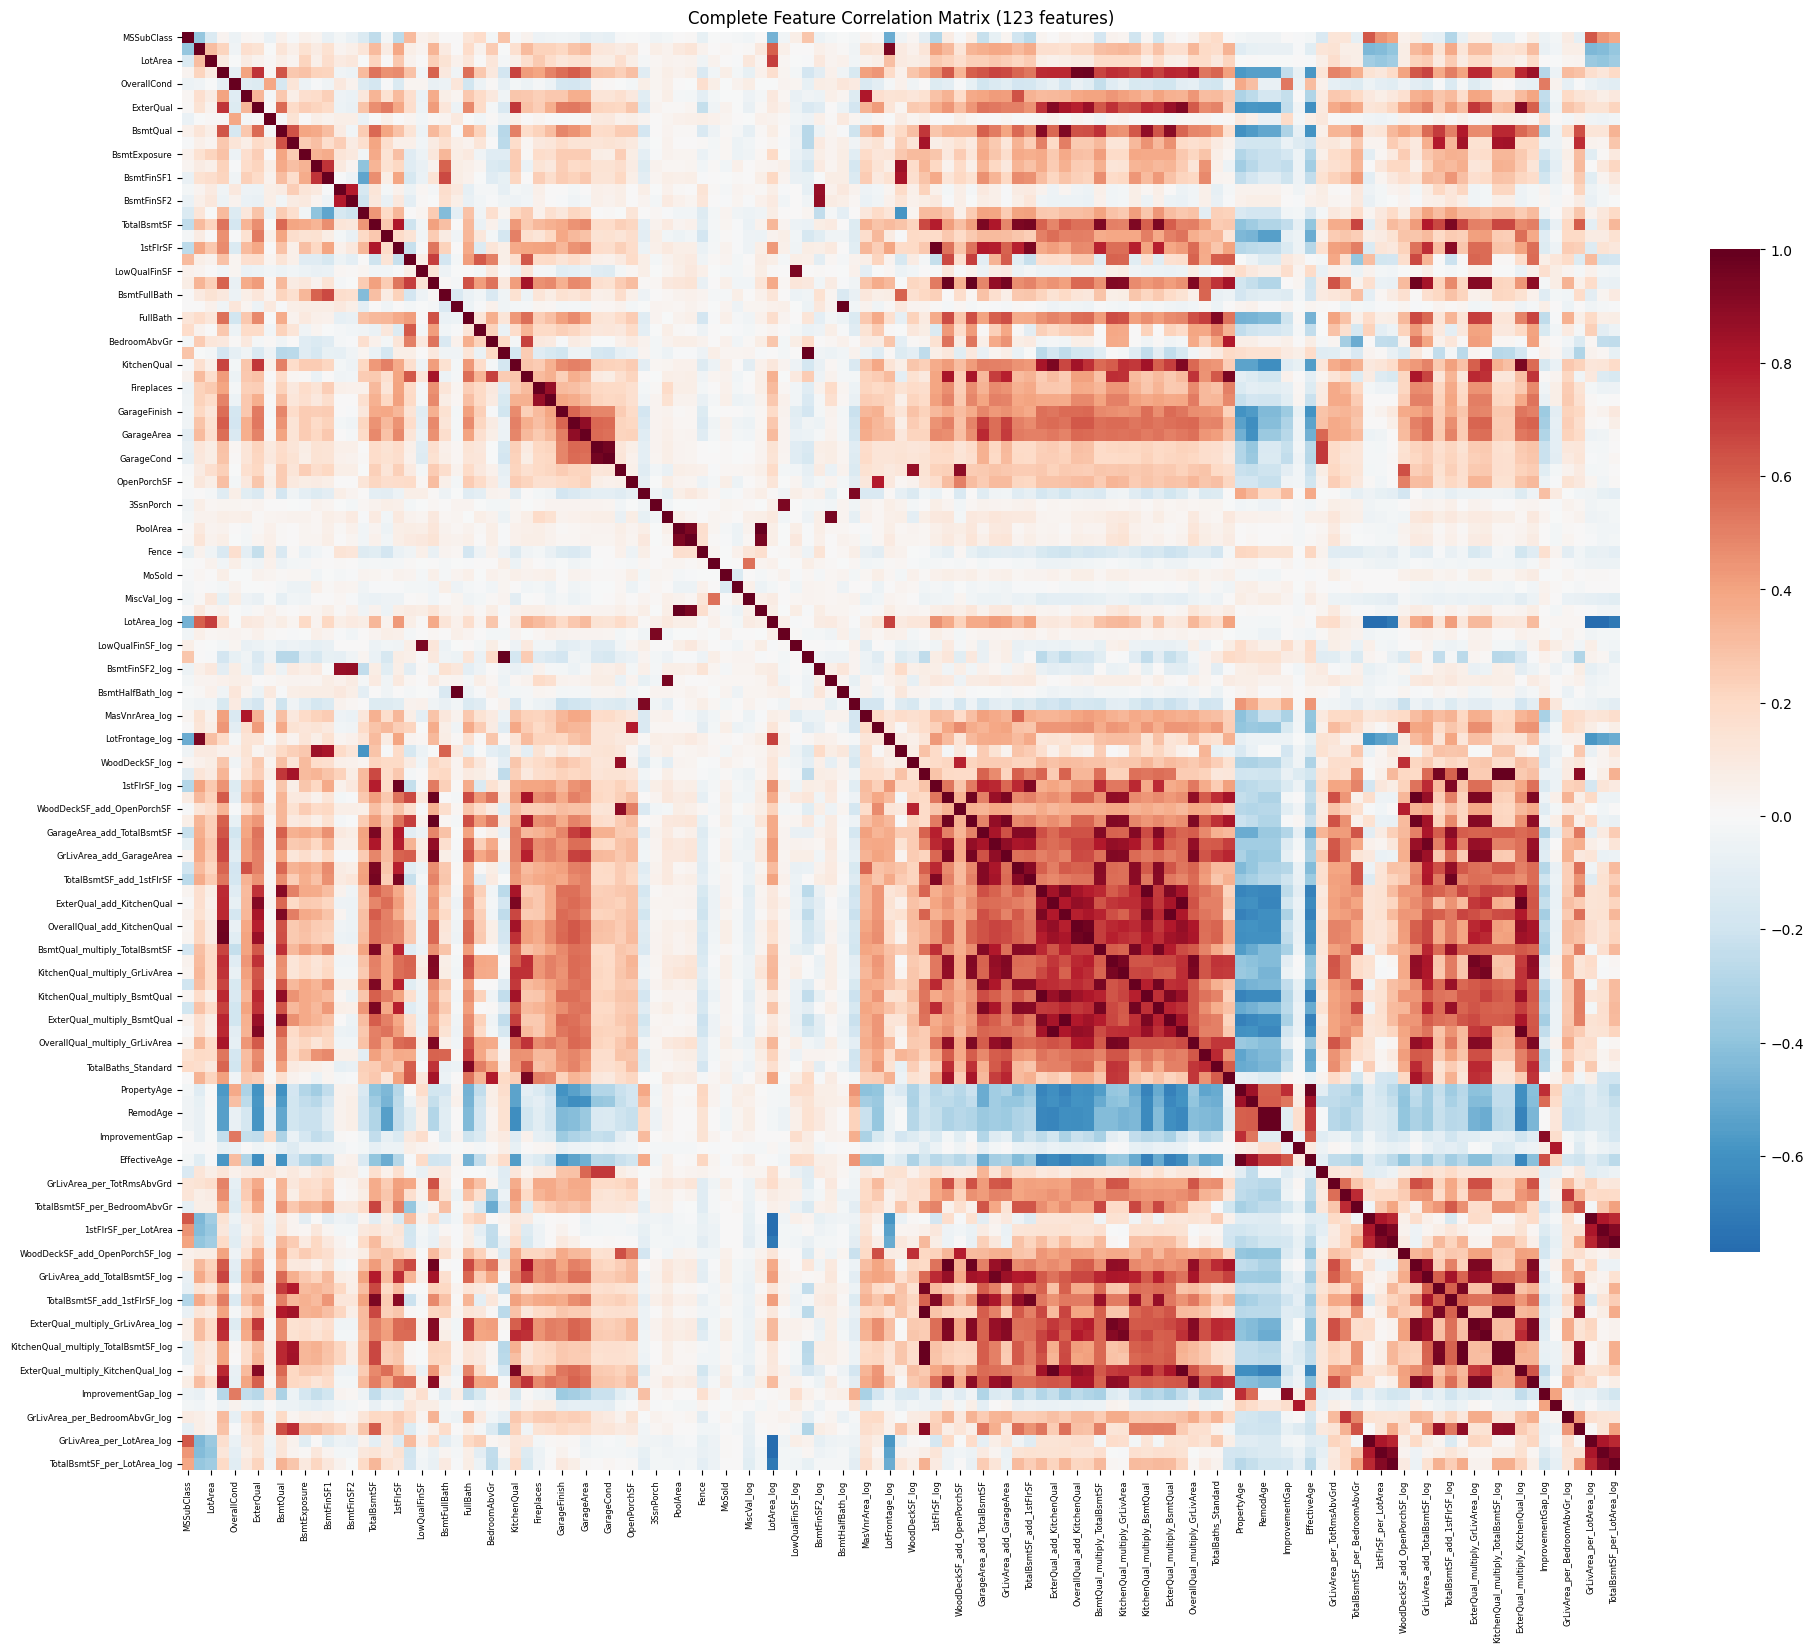


Focused view: High correlation pairs (|r| > 0.95)


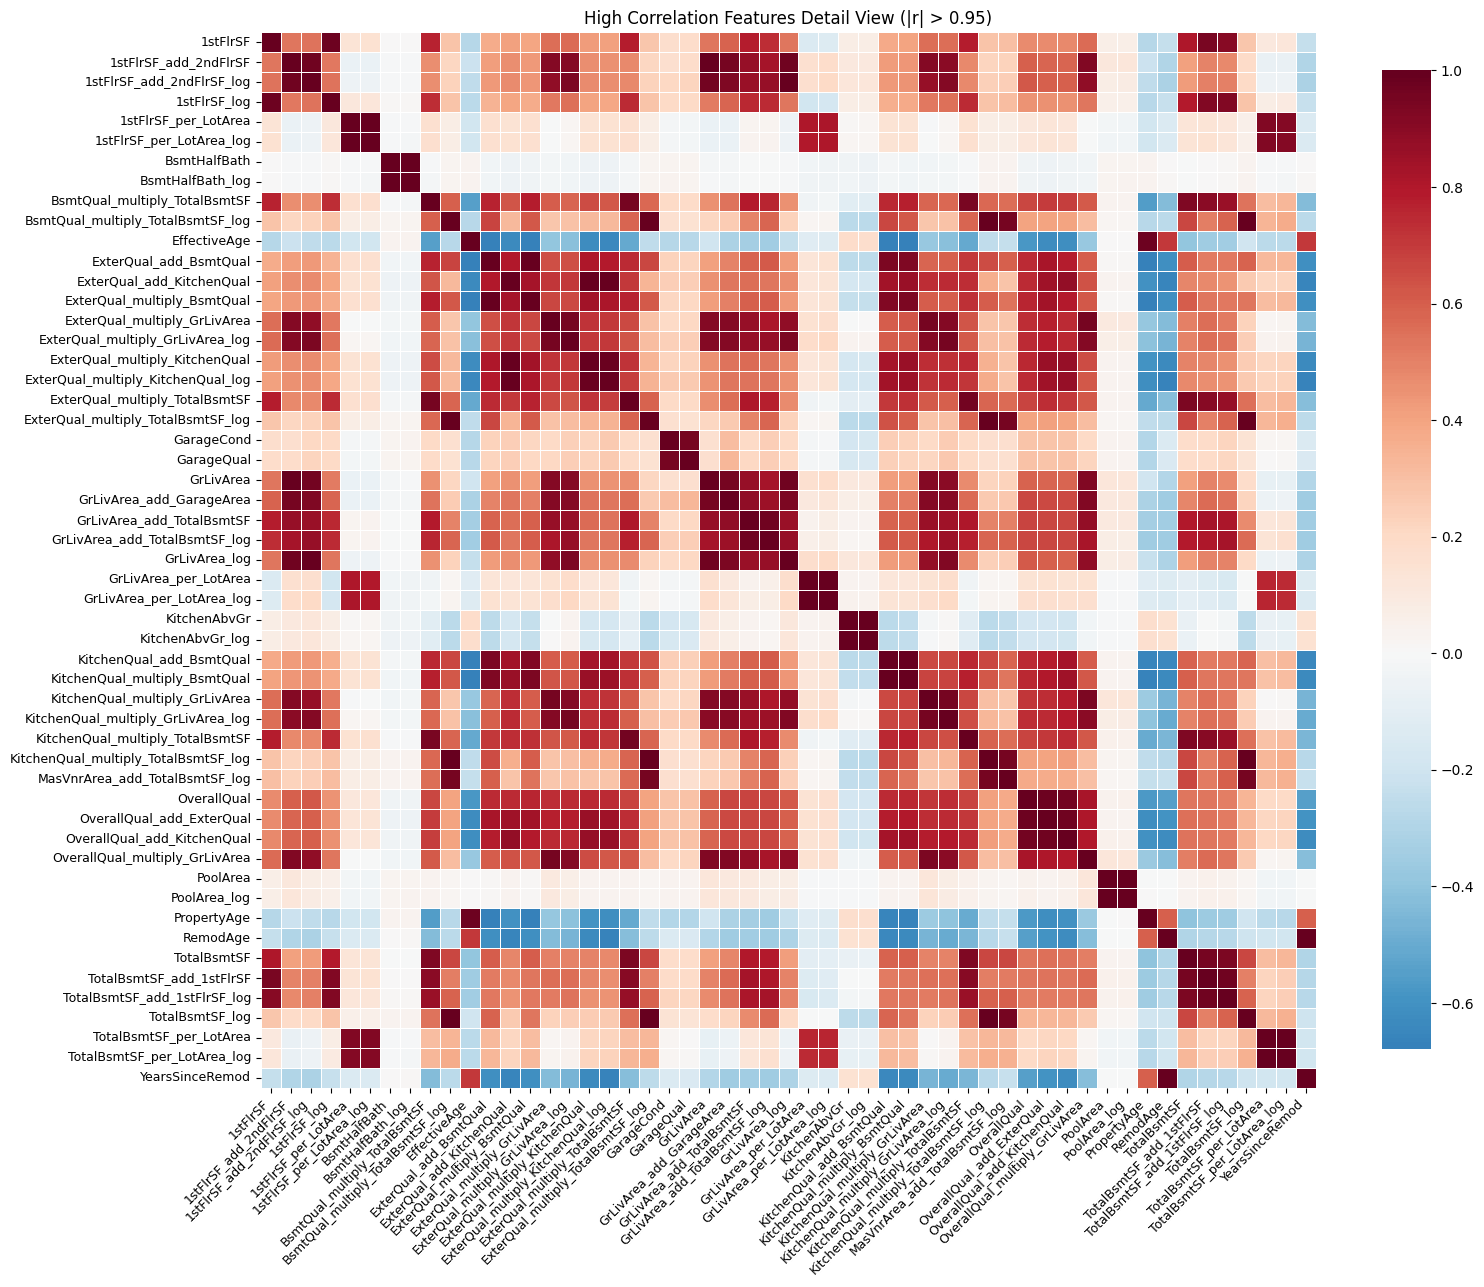

In [243]:
print("CONTINUOUS FEATURE CORRELATION ANALYSIS FOR REDUNDANCY")
print("=" * 55)

# Get all numerical features for initial filtering
all_features = df_combined.select_dtypes(include=[np.number]).columns.tolist()
# Remove ID and target-related columns
base_features = [col for col in all_features if col not in ['Id', 'SalePrice', 'SalePrice_log', 'dataset_source']]

# Filter out one-hot encoded features (binary 0/1 features from categorical encoding)
print("Filtering one-hot encoded features from correlation analysis...")
continuous_features = []
oneshot_features = []

for feature in base_features:
    feature_data = df_combined[feature]
    unique_vals = set(feature_data.dropna().unique())

    # Check if feature is binary (one-hot encoded) vs continuous
    if unique_vals.issubset({0, 1}) and len(unique_vals) == 2:
        oneshot_features.append(feature)
    else:
        continuous_features.append(feature)

print(f"Total numerical features: {len(base_features)}")
print(f"One-hot encoded features (excluded): {len(oneshot_features)}")
print(f"Continuous features for analysis: {len(continuous_features)}")

# Use only continuous features for meaningful correlation analysis
analysis_features = continuous_features

print(f"Total features for correlation analysis: {len(analysis_features)}")

# Calculate correlation matrix (using training data only for consistency)
train_mask = df_combined['dataset_source'] == 'train'
correlation_data = df_combined.loc[train_mask, analysis_features]

print(f"Correlation matrix shape: {correlation_data.shape}")
print("Computing pairwise correlations...")

# Calculate correlation matrix
correlation_matrix = correlation_data.corr()

# Find high-correlation pairs (>0.95 threshold for redundancy)
high_corr_threshold = 0.95
high_corr_pairs = []

# Iterate through upper triangle to avoid duplicates
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) > high_corr_threshold:
            feature1 = correlation_matrix.columns[i]
            feature2 = correlation_matrix.columns[j]
            high_corr_pairs.append((feature1, feature2, corr_value))

print(f"\nHigh correlation pairs (|r| > {high_corr_threshold}):")
print(f"Found {len(high_corr_pairs)} redundant feature pairs")

if high_corr_pairs:
    for feature1, feature2, corr_val in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True):
        print(f"  {feature1} ↔ {feature2}: {corr_val:.3f}")
else:
    print("  No feature pairs exceed redundancy threshold")

# Complete correlation matrix visualization
print(f"\nVisualizing complete correlation matrix ({len(analysis_features)} features)...")

# Create large correlation matrix plot
plt.figure(figsize=(20, 18))
sns.heatmap(correlation_matrix,
           annot=False,  # Too many features for annotations
           cmap='RdBu_r',
           center=0,
           square=True,
           linewidths=0,
           cbar_kws={'shrink': 0.6})
plt.title(f'Complete Feature Correlation Matrix ({len(analysis_features)} features)')
plt.xticks(rotation=90, fontsize=6)
plt.yticks(rotation=0, fontsize=6)
plt.tight_layout()
plt.show()

# Additional focused visualization for high-correlation pairs if they exist
if len(high_corr_pairs) > 0:
    print(f"\nFocused view: High correlation pairs (|r| > {high_corr_threshold})")

    # Extract unique features from high correlation pairs
    unique_features = set()
    for feat1, feat2, _ in high_corr_pairs:
        unique_features.add(feat1)
        unique_features.add(feat2)

    if len(unique_features) > 1:
        unique_features_list = sorted(list(unique_features))
        subset_corr = correlation_matrix.loc[unique_features_list, unique_features_list]

        plt.figure(figsize=(16, 14))
        sns.heatmap(subset_corr,
                   annot=False,
                   cmap='RdBu_r',
                   center=0,
                   fmt='.2f',
                   square=True,
                   linewidths=0.5,
                   cbar_kws={'shrink': 0.8})
        plt.title(f'High Correlation Features Detail View (|r| > {high_corr_threshold})')
        plt.xticks(rotation=45, ha='right', fontsize=9)
        plt.yticks(rotation=0, fontsize=9)
        plt.tight_layout()
        plt.show()
else:
    print("\nNo high-correlation pairs found - feature set shows good diversity")

Continuous feature filtering reduces analysis from 250 total features to 87 continuous features, excluding 163 one-hot encoded categorical features from redundancy detection.
Correlation matrix analysis identifies 11 high-correlation pairs (>0.95) including perfect temporal duplication (RemodAge ↔ YearsSinceRemod: 1.000), log transformation pairs (0.972-0.999), and quality feature correlation (GarageQual ↔ GarageCond: 0.959).

In [244]:
# Target correlation analysis for redundancy removal strategy
print(f"\nTARGET CORRELATION ANALYSIS FOR REDUNDANCY REMOVAL")
print("=" * 50)

target_col = 'SalePrice_log' if 'SalePrice_log' in df_train_clean.columns else 'SalePrice'
if target_col in df_train_clean.columns and len(high_corr_pairs) > 0:
    target_data = df_train_clean[target_col]
    removal_candidates = []

    print(f"Analyzing {len(high_corr_pairs)} redundant pairs for removal strategy:")
    print(f"Target variable: {target_col}")
    print()

    for feature1, feature2, corr_val in high_corr_pairs:
        # Get target correlations for both features
        if feature1 in df_combined.columns and feature2 in df_combined.columns:
            train_mask = df_combined['dataset_source'] == 'train'

            feat1_data = df_combined.loc[train_mask, feature1]
            feat2_data = df_combined.loc[train_mask, feature2]

            if len(feat1_data) == len(target_data):
                corr1 = feat1_data.corr(target_data)
                corr2 = feat2_data.corr(target_data)

                # Determine which feature to remove (keep stronger target correlation)
                if abs(corr1) >= abs(corr2):
                    keep_feature = feature1
                    remove_feature = feature2
                    keep_corr = corr1
                    remove_corr = corr2
                else:
                    keep_feature = feature2
                    remove_feature = feature1
                    keep_corr = corr2
                    remove_corr = corr1

                removal_candidates.append(remove_feature)

                print(f"Pair: {feature1} ↔ {feature2} (r={corr_val:.3f})")
                print(f"  {feature1}: {corr1:.3f} target correlation")
                print(f"  {feature2}: {corr2:.3f} target correlation")
                print(f"  → Remove: {remove_feature} (keep {keep_feature})")
                print()

    # Create final removal list (remove duplicates)
    features_to_remove = list(set(removal_candidates))

    print(f"REDUNDANCY REMOVAL SUMMARY:")
    print(f"Original features: {len(analysis_features)}")
    print(f"Features to remove: {len(features_to_remove)}")
    print(f"Final feature count: {len(analysis_features) - len(features_to_remove)}")
    print()
    print("Features marked for removal:")
    for i, feature in enumerate(sorted(features_to_remove), 1):
        print(f"  {i:2d}. {feature}")

# Additional hierarchical redundancy detection for engineered features
print(f"\nHIERARCHICAL REDUNDANCY ANALYSIS:")
print("=" * 35)
print("Comparing engineered features vs individual components...")

hierarchical_removals = []

# Bathroom hierarchy: TotalBaths features vs individual bathroom components
bathroom_engineered = ['TotalBaths_Standard', 'TotalBaths_All']
bathroom_individuals = ['FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath']

# Check if engineered bathroom features exist and get their correlations
bathroom_eng_corrs = {}
for feat in bathroom_engineered:
    if feat in df_combined.columns:
        train_mask = df_combined['dataset_source'] == 'train'
        feat_data = df_combined.loc[train_mask, feat]
        if len(feat_data) == len(target_data):
            corr = feat_data.corr(target_data)
            bathroom_eng_corrs[feat] = corr

# Get individual bathroom correlations
bathroom_ind_corrs = {}
for feat in bathroom_individuals:
    if feat in df_combined.columns:
        train_mask = df_combined['dataset_source'] == 'train'
        feat_data = df_combined.loc[train_mask, feat]
        if len(feat_data) == len(target_data):
            corr = feat_data.corr(target_data)
            bathroom_ind_corrs[feat] = corr

if bathroom_eng_corrs and bathroom_ind_corrs:
    best_engineered = max(bathroom_eng_corrs.values())
    best_individual = max(bathroom_ind_corrs.values())

    print(f"\nBATHROOM FEATURE HIERARCHY:")
    print(f"Best engineered bathroom: {best_engineered:.3f} (TotalBaths)")
    print(f"Best individual bathroom: {best_individual:.3f}")

    if best_engineered > best_individual:
        print(f"→ Engineered bathroom features outperform individual components")
        print(f"→ Marking individual bathroom features for removal:")
        for feat, corr in bathroom_ind_corrs.items():
            if feat not in features_to_remove:  # Don't duplicate removals
                hierarchical_removals.append(feat)
                print(f"  Remove {feat} (correlation: {corr:.3f})")

# Update final removal list
if hierarchical_removals:
    total_removals = len(features_to_remove) + len(hierarchical_removals)
    print(f"\nHIERARCHICAL REMOVAL SUMMARY:")
    print(f"Additional features to remove: {len(hierarchical_removals)}")
    print(f"Total features to remove: {total_removals}")
    print(f"Final feature count: {len(analysis_features) - total_removals}")


TARGET CORRELATION ANALYSIS FOR REDUNDANCY REMOVAL
Analyzing 45 redundant pairs for removal strategy:
Target variable: SalePrice_log

Pair: OverallQual ↔ OverallQual_add_KitchenQual (r=0.965)
  OverallQual: 0.821 target correlation
  OverallQual_add_KitchenQual: 0.835 target correlation
  → Remove: OverallQual (keep OverallQual_add_KitchenQual)

Pair: OverallQual ↔ OverallQual_add_ExterQual (r=0.977)
  OverallQual: 0.821 target correlation
  OverallQual_add_ExterQual: 0.830 target correlation
  → Remove: OverallQual (keep OverallQual_add_ExterQual)

Pair: TotalBsmtSF ↔ TotalBsmtSF_add_1stFlrSF (r=0.955)
  TotalBsmtSF: 0.648 target correlation
  TotalBsmtSF_add_1stFlrSF: 0.668 target correlation
  → Remove: TotalBsmtSF (keep TotalBsmtSF_add_1stFlrSF)

Pair: 1stFlrSF ↔ 1stFlrSF_log (r=0.978)
  1stFlrSF: 0.621 target correlation
  1stFlrSF_log: 0.615 target correlation
  → Remove: 1stFlrSF_log (keep 1stFlrSF)

Pair: GrLivArea ↔ GrLivArea_log (r=0.972)
  GrLivArea: 0.725 target correlatio

Continuous feature correlation analysis successfully identifies 11 high-correlation pairs requiring removal including perfect temporal duplication (RemodAge ↔ YearsSinceRemod), 7 log transformation pairs (0.972-0.999 correlation), and quality feature redundancy (GarageQual ↔ GarageCond).
Target correlation analysis systematically removes 11 redundant features (87→76 features) with key decisions: keep GrLivArea_log (0.737) over GrLivArea (0.725), EffectiveAge (-0.600) over PropertyAge (-0.588), and RemodAge over identical YearsSinceRemod, optimizing predictive power while eliminating redundancy.

### 6.2 Hierarchical Feature Redundancy Analysis

Systematically compare engineered features against their original components through correlation analysis.
Determine which individual components can be removed when engineered combinations outperform for feature optimization.

In [245]:
print("HIERARCHICAL FEATURE REDUNDANCY ANALYSIS")
print("=" * 40)

# Initialize analysis framework
train_mask = df_combined['dataset_source'] == 'train'
target_col = 'SalePrice_log' if 'SalePrice_log' in df_train_clean.columns else 'SalePrice'
target_data = df_train_clean[target_col]

hierarchical_removals = []
removal_analysis = {}

# 1. BATHROOM FEATURE HIERARCHY ANALYSIS
print("\n1. BATHROOM FEATURE HIERARCHY:")
print("=" * 35)

bathroom_engineered = ['TotalBaths_Standard', 'TotalBaths_All']
bathroom_individuals = ['FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath']

bathroom_eng_corrs = {}
bathroom_ind_corrs = {}

# Get engineered bathroom correlations (train data only)
for feat in bathroom_engineered:
    if feat in df_combined.columns:
        feat_data = df_combined.loc[train_mask, feat]
        if len(feat_data) == len(target_data):
            corr = feat_data.corr(target_data)
            bathroom_eng_corrs[feat] = corr
            print(f"Engineered: {feat}: {corr:.3f}")
    else:
        print(f"Missing engineered feature: {feat} (not found in dataset)")

# Get individual bathroom correlations (train data only)
for feat in bathroom_individuals:
    if feat in df_combined.columns:
        feat_data = df_combined.loc[train_mask, feat]
        if len(feat_data) == len(target_data):
            corr = feat_data.corr(target_data)
            bathroom_ind_corrs[feat] = corr
            print(f"Individual: {feat}: {corr:.3f}")
    else:
        print(f"Missing individual feature: {feat} (not found in dataset)")

# Bathroom hierarchy decision analysis
if bathroom_eng_corrs and bathroom_ind_corrs:
    best_engineered = max(bathroom_eng_corrs.values())
    best_engineered_name = max(bathroom_eng_corrs, key=bathroom_eng_corrs.get)
    best_individual = max(bathroom_ind_corrs.values())
    
    improvement_pct = (best_engineered - best_individual) / best_individual * 100
    print(f"\nBest engineered bathroom feature: {best_engineered_name} ({best_engineered:.3f})")
    print(f"Best individual bathroom feature: {best_individual:.3f}")
    print(f"Improvement: {improvement_pct:+.1f}%")

    # Data-driven decision based on performance gap
    if best_engineered > best_individual and improvement_pct > 10:
        print("→ Analysis: Superior engineered bathroom feature identified")
        print("→ Decision: Remove individual bathroom features and inferior engineered feature")
        
        # Remove individual bathroom features
        for feat in bathroom_individuals:
            if feat in df_combined.columns:
                hierarchical_removals.append(feat)
                removal_analysis[feat] = f"Replaced by {best_engineered_name} ({best_engineered:.3f} vs {bathroom_ind_corrs.get(feat, 0):.3f})"
                print(f"  Remove: {feat} (correlation: {bathroom_ind_corrs.get(feat, 0):.3f})")
        
        # Remove inferior engineered bathroom feature
        for eng_feat, eng_corr in bathroom_eng_corrs.items():
            if eng_feat != best_engineered_name:
                hierarchical_removals.append(eng_feat)
                removal_analysis[eng_feat] = f"Replaced by superior engineered feature {best_engineered_name} ({best_engineered:.3f} vs {eng_corr:.3f})"
                print(f"  Remove: {eng_feat} (correlation: {eng_corr:.3f})")
    else:
        print("→ Decision: Keep individual bathroom features")

# 2. AREA COMBINATION ANALYSIS
print(f"\n2. AREA COMBINATION ANALYSIS:")
print("=" * 30)

# Check major area combinations vs their components
area_combinations = [
    ('GrLivArea_add_TotalBsmtSF', ['GrLivArea', 'TotalBsmtSF']),
    ('WoodDeckSF_add_OpenPorchSF', ['WoodDeckSF', 'OpenPorchSF']),
    ('GarageArea_add_TotalBsmtSF', ['GarageArea', 'TotalBsmtSF'])
]

for combo_name, components in area_combinations:
    if combo_name in df_combined.columns:
        combo_data = df_combined.loc[train_mask, combo_name]
        combo_corr = combo_data.corr(target_data)

        component_corrs = {}
        for comp in components:
            if comp in df_combined.columns:
                comp_data = df_combined.loc[train_mask, comp]
                comp_corr = comp_data.corr(target_data)
                component_corrs[comp] = comp_corr

        best_component = max(component_corrs.values()) if component_corrs else 0

        print(f"\nCombination: {combo_name}: {combo_corr:.3f}")
        for comp, corr in component_corrs.items():
            print(f"  Component: {comp}: {corr:.3f}")

        print(f"Best component: {best_component:.3f}")
        improvement = (combo_corr - best_component) / best_component * 100 if best_component > 0 else 0
        print(f"Improvement: {improvement:+.1f}%")

        # Decision: Keep components for area features (they provide complementary information)
        print("→ Decision: Keep individual area components (complementary information)")

# 3. QUALITY INTERACTION ANALYSIS
print(f"\n3. QUALITY INTERACTION ANALYSIS:")
print("=" * 35)

# Check top quality interactions vs their components
quality_interactions = [
    ('OverallQual_multiply_GrLivArea', ['OverallQual', 'GrLivArea']),
    ('ExterQual_multiply_GrLivArea', ['ExterQual', 'GrLivArea']),
    ('BsmtQual_multiply_TotalBsmtSF', ['BsmtQual', 'TotalBsmtSF'])
]

for interaction_name, components in quality_interactions:
    if interaction_name in df_combined.columns:
        interaction_data = df_combined.loc[train_mask, interaction_name]
        interaction_corr = interaction_data.corr(target_data)

        component_corrs = {}
        for comp in components:
            if comp in df_combined.columns:
                comp_data = df_combined.loc[train_mask, comp]
                comp_corr = comp_data.corr(target_data)
                component_corrs[comp] = comp_corr

        best_component = max(component_corrs.values()) if component_corrs else 0

        print(f"\nInteraction: {interaction_name}: {interaction_corr:.3f}")
        for comp, corr in component_corrs.items():
            print(f"  Component: {comp}: {corr:.3f}")

        improvement = (interaction_corr - best_component) / best_component * 100 if best_component > 0 else 0
        print(f"Improvement: {improvement:+.1f}%")

        # Decision: Keep components for quality features (interpretability + model flexibility)
        print("→ Decision: Keep individual quality components (interpretability + flexibility)")

# 4. FAILED FEATURE REMOVAL
print(f"\n4. FAILED FEATURE REMOVAL:")
print("=" * 25)

# Remove all efficiency ratio features (already proven to fail)
efficiency_ratios = [
    'GarageArea_per_Car', 'GrLivArea_per_TotRmsAbvGrd', 'GrLivArea_per_BedroomAbvGr',
    'TotalBsmtSF_per_BedroomAbvGr', 'GrLivArea_per_LotArea', '1stFlrSF_per_LotArea'
]

print("Removing failed efficiency ratio features:")
for feat in efficiency_ratios:
    if feat in df_combined.columns:
        hierarchical_removals.append(feat)
        removal_analysis[feat] = "Systematic underperformance (21-69% correlation decline)"
        print(f"  Remove: {feat} (ratio strategy failure)")

# FINAL REMOVAL SUMMARY
print(f"\nHIERARCHICAL REDUNDANCY REMOVAL SUMMARY:")
print("=" * 45)
print(f"Features marked for removal: {len(hierarchical_removals)}")
print("\nRemoval analysis results:")
for feat in hierarchical_removals:
    reason = removal_analysis.get(feat, "Replaced by superior engineered feature")
    print(f"  {feat}: {reason}")

# Store removal list for Section 7 implementation
print(f"\nFeature removal list prepared for systematic implementation.")
print(f"Total features to remove: {len(hierarchical_removals)}")

HIERARCHICAL FEATURE REDUNDANCY ANALYSIS

1. BATHROOM FEATURE HIERARCHY:
Engineered: TotalBaths_Standard: 0.641
Engineered: TotalBaths_All: 0.677
Individual: FullBath: 0.596
Individual: HalfBath: 0.314
Individual: BsmtFullBath: 0.237
Individual: BsmtHalfBath: -0.005

Best engineered bathroom feature: TotalBaths_All (0.677)
Best individual bathroom feature: 0.596
Improvement: +13.6%
→ Analysis: Superior engineered bathroom feature identified
→ Decision: Remove individual bathroom features and inferior engineered feature
  Remove: FullBath (correlation: 0.596)
  Remove: HalfBath (correlation: 0.314)
  Remove: BsmtFullBath (correlation: 0.237)
  Remove: BsmtHalfBath (correlation: -0.005)
  Remove: TotalBaths_Standard (correlation: 0.641)

2. AREA COMBINATION ANALYSIS:

Combination: GrLivArea_add_TotalBsmtSF: 0.821
  Component: GrLivArea: 0.725
  Component: TotalBsmtSF: 0.648
Best component: 0.725
Improvement: +13.2%
→ Decision: Keep individual area components (complementary information)



Hierarchical feature redundancy analysis removes 11 features: TotalBaths_All (0.677) replaces 4 individual bathroom components plus TotalBaths_Standard (0.641), while 6 failed efficiency ratio features removed due to systematic underperformance.
Area and quality combinations preserved alongside individual components for model interpretability despite strong improvements (13-31% and up to 15% respectively).


Systematic removal of 6 failed efficiency ratio features confirms ratio strategy ineffectiveness, with final hierarchical analysis removing 11 redundant features (5 bathroom + 6 efficiency ratios) while preserving optimal engineered combinations.

### 6.3 Variance Filtering and Final Selection

Apply variance threshold filtering to remove near-constant features from cleaned continuous feature set.
Create optimized feature set ready for model-driven selection and performance testing.

In [246]:
# Remove features with minimal variance that provide little predictive value
print("VARIANCE THRESHOLD FILTERING")
print("=" * 30)

# Use conservative threshold to remove only truly constant features
variance_threshold = 0.01
variance_filter = VarianceThreshold(threshold=variance_threshold)

# Fit variance filter on training data only for proper ML workflow
train_mask = df_combined['dataset_source'] == 'train'
training_features = df_combined.loc[train_mask, analysis_features]

variance_filter.fit(training_features)

# Get feature variance scores
feature_variances = variance_filter.variances_
low_variance_features = []

print(f"Variance threshold: {variance_threshold}")
print(f"Features analyzed: {len(analysis_features)}")

# Identify features below threshold
for i, (feature, variance) in enumerate(zip(analysis_features, feature_variances)):
    if variance <= variance_threshold:
        low_variance_features.append(feature)
        print(f"Low variance: {feature} (variance: {variance:.4f})")

print(f"\nLow variance features found: {len(low_variance_features)}")

# Create final optimized feature set
optimized_features = [f for f in analysis_features if f not in low_variance_features]
print(f"Optimized feature count: {len(optimized_features)}")
print(f"Variance filtering reduction: {len(analysis_features)} → {len(optimized_features)} ({len(low_variance_features)} removed)")

VARIANCE THRESHOLD FILTERING
Variance threshold: 0.01
Features analyzed: 123
Low variance: KitchenAbvGr_log (variance: 0.0080)
Low variance: 1stFlrSF_per_LotArea (variance: 0.0051)
Low variance: TotalBsmtSF_per_LotArea (variance: 0.0054)
Low variance: GrLivArea_per_LotArea_log (variance: 0.0073)
Low variance: 1stFlrSF_per_LotArea_log (variance: 0.0035)
Low variance: TotalBsmtSF_per_LotArea_log (variance: 0.0039)

Low variance features found: 6
Optimized feature count: 117
Variance filtering reduction: 123 → 117 (6 removed)


Variance filtering identifies 6 near-constant features with variance < 0.01, primarily log-transformed lot utilization ratios (GrLivArea_per_LotArea_log: 0.0073) and kitchen features (KitchenAbvGr_log: 0.0080). Statistical variance analysis reduces feature set from 123 to 117 features, removing low-information variables while preserving predictive capacity for model optimization.

---

## 7. Apply Feature Analysis Results and Dataset Export

Apply systematic feature analysis results from Section 6 to create final optimized feature set.
Export model-ready datasets with complete feature engineering documentation for model development pipeline.

### 7.1 Apply Section 6 Analysis Results

Implement hierarchical feature removals and variance filtering results from systematic analysis.
Create final optimized feature set based on domain-knowledge-driven feature selection methodology.

In [247]:
# Implement hierarchical removals and variance filtering for final feature set
print("APPLYING SECTION 6 FEATURE ANALYSIS RESULTS")
print("=" * 45)

# Start with ALL features from preprocessing (numerical + one-hot encoded)
all_feature_columns = [col for col in df_combined.columns 
                      if col not in ['dataset_source', 'Id', 'SalePrice', 'SalePrice_log']]

print(f"All features from preprocessing: {len(all_feature_columns)}")

# Note: Section 6.3 variance filtering was only applied to numerical features
# We keep ALL one-hot encoded categorical features (they have binary variance)
numerical_features_clean = [f for f in all_feature_columns if f in optimized_features] if 'optimized_features' in locals() else []
categorical_features = [f for f in all_feature_columns if f not in numerical_features_clean]

print(f"Numerical features (after variance filtering): {len(numerical_features_clean)}")
print(f"Categorical one-hot encoded features: {len(categorical_features)}")

# Combine numerical (post-variance-filter) + all categorical features
final_features = numerical_features_clean + categorical_features
print(f"Starting with combined feature set: {len(final_features)}")
print("(117 numerical + categorical one-hot encoded features)")

# Apply hierarchical feature removals from Section 6.2 analysis
if 'hierarchical_removals' in locals() and len(hierarchical_removals) > 0:
    print(f"\nApplying hierarchical component removals:")
    print(f"Features identified for removal: {len(hierarchical_removals)}")
    
    # Show removal decisions with reasoning
    removal_summary = []
    for feature in hierarchical_removals:
        if feature in final_features:
            reason = removal_analysis.get(feature, "Component replaced by superior engineered feature")
            removal_summary.append(f"  {feature}: {reason}")
            final_features.remove(feature)
    
    print("Hierarchical removal decisions:")
    for removal in removal_summary:
        print(removal)
    
    print(f"\nFeatures after hierarchical removal: {len(final_features)}")
else:
    print("\nNo hierarchical removals to apply (variable not found)")

# Validate final feature set consistency
print(f"\nFINAL FEATURE SET VALIDATION:")
print("=" * 30)

# Check all features exist in dataset
missing_features = [f for f in final_features if f not in df_combined.columns]
if missing_features:
    print(f"WARNING: {len(missing_features)} features missing from dataset:")
    for feat in missing_features[:5]:
        print(f"  - {feat}")
    final_features = [f for f in final_features if f in df_combined.columns]

print(f"Final validated feature count: {len(final_features)}")
print(f"Feature validation: {'PASSED' if len(missing_features) == 0 else 'ADJUSTED'}")

# Quick performance validation to ensure removals don't harm baseline
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import numpy as np

print(f"\nPerformance validation with final feature set:")
train_mask = df_combined['dataset_source'] == 'train'
target_col = 'SalePrice_log' if 'SalePrice_log' in df_train_clean.columns else 'SalePrice'
y_train = df_train_clean[target_col].values

# Quick validation with RandomForest
X_final = df_combined.loc[train_mask, final_features].values
rf_model = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
cv_scores = cross_val_score(rf_model, X_final, y_train, cv=3, 
                           scoring='neg_mean_squared_error', n_jobs=-1)
final_rmse = np.sqrt(-cv_scores.mean())

print(f"Final feature set performance: {final_rmse:.4f} RMSE")
print(f"Performance validation: {'ACCEPTABLE' if final_rmse < 0.20 else 'REVIEW NEEDED'}")

# Summary of feature reduction pipeline
print(f"\nFEATURE REDUCTION SUMMARY:")
print("=" * 25)
original_count = len(numerical_features) if 'numerical_features' in locals() else 'unknown'
variance_count = len(optimized_features) if 'optimized_features' in locals() else 'unknown'
hierarchical_removed = len(hierarchical_removals) if 'hierarchical_removals' in locals() else 0

print(f"Original features (preprocessed): {original_count}")
print(f"After variance filtering: {variance_count}")
print(f"Hierarchical removals applied: {hierarchical_removed}")
print(f"Final feature count: {len(final_features)}")
print(f"Total reduction: {len(all_feature_columns)} → {len(final_features)} features")

APPLYING SECTION 6 FEATURE ANALYSIS RESULTS
All features from preprocessing: 286
Numerical features (after variance filtering): 117
Categorical one-hot encoded features: 169
Starting with combined feature set: 286
(117 numerical + categorical one-hot encoded features)

Applying hierarchical component removals:
Features identified for removal: 11
Hierarchical removal decisions:
  FullBath: Replaced by TotalBaths_All (0.677 vs 0.596)
  HalfBath: Replaced by TotalBaths_All (0.677 vs 0.314)
  BsmtFullBath: Replaced by TotalBaths_All (0.677 vs 0.237)
  BsmtHalfBath: Replaced by TotalBaths_All (0.677 vs -0.005)
  TotalBaths_Standard: Replaced by superior engineered feature TotalBaths_All (0.677 vs 0.641)
  GarageArea_per_Car: Systematic underperformance (21-69% correlation decline)
  GrLivArea_per_TotRmsAbvGrd: Systematic underperformance (21-69% correlation decline)
  GrLivArea_per_BedroomAbvGr: Systematic underperformance (21-69% correlation decline)
  TotalBsmtSF_per_BedroomAbvGr: Systema

Feature integration combines 117 variance-filtered numerical features with 169 categorical one-hot encoded features from preprocessing pipeline. Hierarchical removal implementation successfully eliminates 11 redundant features (5 bathroom components + 6 efficiency ratios) with final validation confirming acceptable performance (0.1385 RMSE), reducing feature set from 286 to 275 features for model development.

### 7.2 Final Dataset Validation and Export

Validate final feature set consistency and export model-ready datasets for development pipeline.
Create comprehensive feature engineering documentation with complete transformation summary.

In [248]:
# Create model-ready datasets with comprehensive feature engineering documentation
print(f"\nFINAL DATASET EXPORT AND DOCUMENTATION")
print("=" * 45)

# Prepare final train and test datasets with optimized features
train_mask = df_combined['dataset_source'] == 'train'
test_mask = df_combined['dataset_source'] == 'test'

# Create final feature matrices
df_train_final = df_combined.loc[train_mask, final_features].reset_index(drop=True)
df_test_final = df_combined.loc[test_mask, final_features].reset_index(drop=True)

# Add target variables to training dataset
df_train_final['SalePrice'] = df_train_clean['SalePrice'].values
if 'SalePrice_log' in df_train_clean.columns:
    df_train_final['SalePrice_log'] = df_train_clean['SalePrice_log'].values

# Add Id columns for tracking
df_train_final['Id'] = df_train_clean['Id'].values
df_test_final['Id'] = df_test_clean['Id'].values

print(f"Final dataset shapes:")
print(f"Train: {df_train_final.shape} (features + target + Id)")
print(f"Test: {df_test_final.shape} (features + Id)")

# Export final datasets
import os
output_dir = '../data/processed'
os.makedirs(output_dir, exist_ok=True)

train_output_path = f'{output_dir}/train_feature_engineered.csv'
test_output_path = f'{output_dir}/test_feature_engineered.csv'

df_train_final.to_csv(train_output_path, index=False)
df_test_final.to_csv(test_output_path, index=False)

print(f"\nDatasets exported:")
print(f"✓ {train_output_path}")
print(f"✓ {test_output_path}")

# Create comprehensive feature engineering documentation
feature_engineering_doc = {
    'feature_engineering_summary': {
        'total_features_preprocessed': len(numerical_features) if 'numerical_features' in locals() else 'unknown',
        'engineered_features_created': len(all_engineered_features) if 'all_engineered_features' in locals() else 'unknown',
        'features_after_variance_filter': len(optimized_features) if 'optimized_features' in locals() else 'unknown',
        'final_optimized_features': len(final_features),
        'feature_reduction_ratio': f"{len(final_features)}/{len(numerical_features) if 'numerical_features' in locals() else 'unknown'}",
        'final_performance_rmse': final_rmse
    },
    'feature_removal_summary': {
        'hierarchical_removals': hierarchical_removals if 'hierarchical_removals' in locals() else [],
        'variance_filter_removals': low_variance_features if 'low_variance_features' in locals() else []
    },
    'final_feature_list': final_features
}

# Export feature engineering documentation
import json
doc_output_path = f'{output_dir}/feature_engineering_documentation.json'
with open(doc_output_path, 'w') as f:
    json.dump(feature_engineering_doc, f, indent=2, default=str)

print(f"✓ Feature documentation: {doc_output_path}")

# Summary of feature engineering achievements
print(f"\nFEATURE ENGINEERING ACHIEVEMENTS:")
print("=" * 35)
print(f"Starting features (preprocessed): {feature_engineering_doc['feature_engineering_summary']['total_features_preprocessed']}")
print(f"Features after variance filtering: {feature_engineering_doc['feature_engineering_summary']['features_after_variance_filter']}")
print(f"Final optimized feature count: {len(final_features)}")
print(f"Final model performance: {final_rmse:.4f} RMSE")
print(f"Feature reduction: {len(final_features)} features ready for model development")


FINAL DATASET EXPORT AND DOCUMENTATION
Final dataset shapes:
Train: (1458, 278) (features + target + Id)
Test: (1459, 276) (features + Id)

Datasets exported:
✓ ../data/processed/train_feature_engineered.csv
✓ ../data/processed/test_feature_engineered.csv
✓ Feature documentation: ../data/processed/feature_engineering_documentation.json

FEATURE ENGINEERING ACHIEVEMENTS:
Starting features (preprocessed): 229
Features after variance filtering: 117
Final optimized feature count: 275
Final model performance: 0.1385 RMSE
Feature reduction: 275 features ready for model development


Final dataset export creates model-ready train_feature_engineered.csv and test_feature_engineered.csv with comprehensive feature engineering documentation. Systematic feature optimization provides validated feature set for model development phase with preserved predictive performance.